In [1]:
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
import urllib.request, json
import scipy.stats as stats
import statsmodels.api as sm

from metloom.pointdata import MesowestPointData, SnotelPointData
import dataretrieval.nwis as nwis
import pyet
import metpy.calc as calc
from metpy.units import units


import ftplib
import io
import warnings
import datetime as dt
import xarray as xr


# Visualization
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns


## Functions

In [2]:
def calc_net_lw_radiation(temperature, relative_humidity, elevation, dew_pt_temp=None):
    """Compute net longwave clear sky radiation from temperature measurements, relative humidy values and site elevation


    Args:
        temperature (array-like): mean daily temperatures (C)
        relative_humidity (array-like): mean relative humidity (%)
        elevation (float): site elevation (m)
        dew_pt_temp (array-like, optional): Dew point temperature, include if measured. Defaults to None.

    Returns:
        Series: net longwave radiations in W/m2
    """
    SIGMA = 5.67e-8
    CONSTANT = 40

    # Convert temperature to Kelvin
    temperature_K = temperature.to_xarray().squeeze()+273.15
    temperature_K.attrs = {'units':'K'}


    # Using Marks & Dozier, 1979 to calculate emissivity 
    T_prime = temperature_K + (0.0065 * elevation)
    T_prime.attrs = {'units':'K'}
    e_prime = relative_humidity*calc.saturation_vapor_pressure(T_prime)/100
    
    # Hydrostatic pressure
    standard_p = 101325*((293+(elevation*-0.0065))/293)**(-9.81*0.0299/(-.0065*8.314))
    # Emissivity estimate
    epsilon_atmos=(1.24 * (e_prime/T_prime)**(1/7) * (standard_p)/101300)

    # Longwave in estimate
    lw_in = epsilon_atmos * SIGMA * temperature_K**4 - CONSTANT

    # Calculate longwave out
    if dew_pt_temp is None:
        dew_pt_temp = calc.dewpoint_from_relative_humidity(temperature_K,(relative_humidity/100).to_xarray()).values
    lw_out = SIGMA*(dew_pt_temp+273.15)**4

    # Compute net longwave radiation
    rnet = lw_in - lw_out
    return rnet

def normalize_data(df):
    '''Normalized a pandas series'''
    norm = (df - df.mean())/df.std()
    norm.index = norm.index.astype(int)
    return norm

# Take from https://stackoverflow.com/questions/22852244/how-to-get-the-numerical-fitting-results-when-plotting-a-regression-in-seaborn
def simple_regplot(
    x, y, n_std=2, n_pts=100, ax=None, scatter_kws=None, line_kws=None, ci_kws=None
):
    """ Draw a regression line with error interval. """
    ax = plt.gca() if ax is None else ax

    # calculate best-fit line and interval
    x_fit = sm.add_constant(x)
    fit_results = sm.OLS(y, x_fit).fit()

    eval_x = sm.add_constant(np.linspace(np.min(x), np.max(x), n_pts))
    pred = fit_results.get_prediction(eval_x)

    # draw the fit line and error interval
    ci_kws = {} if ci_kws is None else ci_kws
    ax.fill_between(
        eval_x[:, 1],
        pred.predicted_mean - n_std * pred.se_mean,
        pred.predicted_mean + n_std * pred.se_mean,
        alpha=0.2,
        **ci_kws,
        label='95% CI'
    )
    line_kws = {} if line_kws is None else line_kws
    h = ax.plot(eval_x[:, 1], pred.predicted_mean, **line_kws)

    # draw the scatterplot
    scatter_kws = {} if scatter_kws is None else scatter_kws
    ax.scatter(x, y, c=h[0].get_color(), **scatter_kws)
    ax.legend()
    return fit_results

def nse(targets,predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2))


In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
def polynomial_regression(X, y, order=1, confidence=90, num=100):
    c = 1 - ((1 - (confidence / 100)) / 2)
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x=X, y=y)
    
    # Create regression line and residuals
    y_predicted = intercept + slope*X
    residual = (y-y_predicted)

    # Setup 
    n = X.size                     
    m = 2                          
    dof = n - m  
    t = stats.t.ppf(c, dof) 

    # sum of squared errors
    sse = np.sum(residual**2)

    # total sum of squares (y)
    sst = np.sum( (y - np.mean(y))**2 )

    # total sum of squares (x)
    sst_x = np.sum( (X - np.mean(X))**2 )

    # correlation coefficient
    r_squared = 1 - sse/sst

    # standard error of regression
    s = np.sqrt(sse/(n-2))

    # an array of x values
    p_x = np.linspace(X.min(),X.max(),100)

    # using our model parameters to predict y values
    p_y = intercept + slope*p_x

    # compute error of prediction for each p_x
    sigma_ep = np.sqrt( s**2 * (1+ 1/n + ( ( n*(p_x-X.mean())**2 ) / ( n*np.sum(X**2) - np.sum(X)**2 ) ) ) )
    # set our confidence interval

    p_y_lower = p_y - t * sigma_ep
    p_y_upper = p_y + t * sigma_ep

    return p_x, p_y, p_y_lower, p_y_upper, residual, r_squared, confidence

def plot_regression(X,y,order=1, ax=None, positive=False):

    X_line, y_model, p_y_lower, p_y_upper, residual, r2, c = polynomial_regression(X, y, order=order)
    if ax:
        ax.scatter(X, y)
        if positive:
            ax.plot([X.min(),X.max()],[X.min(),X.max()],label='1 to 1 line', color='grey',ls='dotted')
        else:
            ax.plot([X.min(),X.max()],[X.max(),X.min()],label='negative 1 to 1 line', color='grey',ls='dotted')
        # ax.plot(X_line, y_model, label=f'OLS R$^2$ = {round(r2,2)}')
        # ax.fill_between(X_line, p_y_lower, p_y_upper, alpha=.2, label=f'Y prediction interval ({c}%)')
        ax.legend()
        return ax,residual
    else: 
        return residual

def plot_discharge_swe_relationship( site, peak_swe_vals, start_year, end_year=2021, ax=None,labels=None, spring_only=False):
    """Plots discharge-swe relationship and returns residuals of the regression

    Args:
        site (_type_): _description_
        peak_swe_vals (_type_): _description_
        start_year (int, optional): _description_. Defaults to 1991.
        end_year (int, optional): _description_. Defaults to 2021.
        labels (_type_, optional): _description_. Defaults to None.
        spring_only (bool, optional): _description_. Defaults to False.
        savefig (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    # Used for labeling if not provided
    if labels is None:
        labels = {'swe_source':'Not Specified', 'sublimation_source':'Not Specified'}

    # Normalize swe data and sublimation data
    max_swe_mm_normalized = normalize_data(peak_swe_vals)

    # Unchanged values
    idx_mask = max_swe_mm_normalized.loc[start_year:end_year].index
    filtered_max_swe = max_swe_mm_normalized.loc[idx_mask]

    # Get monthly mean discharge
    monthly_discharge_stats = nwis.get_stats(sites=site, statReportType='monthly', statTypeCd='mean')[0]
    monthly_discharge_stats = monthly_discharge_stats[monthly_discharge_stats['parameter_cd']==60]

    # Compute discharge means
    # If only spring is wanted, filter out other months
    if spring_only:
        monthly_discharge_stats = monthly_discharge_stats[monthly_discharge_stats['month_nu'].isin([5,6,7])]
    discharge_means = monthly_discharge_stats['mean_va'].groupby(monthly_discharge_stats['year_nu']).mean()
    discharge_means_normalized = normalize_data(discharge_means)
    
    # Plots if this is True
    # gets the residuals of the linear regression and plots the linear regression for swe vs discharge as well
    
    if ax != None:
        ax, residual  = plot_regression(filtered_max_swe,discharge_means_normalized.loc[idx_mask], ax=ax, positive=True)
        ax.set_ylabel('Normalized Discharge')
        ax.set_xlabel('Normalized Peak SWE')
            # Annotate with the years
        for j, txt in enumerate(filtered_max_swe.index):
            ax.annotate(txt, (filtered_max_swe.iloc[j], discharge_means_normalized.loc[idx_mask].iloc[j]))
        if spring_only:
            ax.set_title(f"Normalized Discharge for Months {', '.join([str(i) for i in monthly_discharge_stats['month_nu'].unique()])}\nvs. Normalized Peak SWE")
        else:
            ax.set_title(f"Normalized Annual Discharge at {site}\nvs.Normalized Peak SWE")
    else:
        residual = plot_regression(filtered_max_swe,discharge_means_normalized.loc[idx_mask], ax=ax)
    return residual

def plot_predictor_residual_relationship(ax, predictor_vals, residual, start_year, end_year=2021, labels={'title':'None', 'xlabel':'Predictor'},positive=False):
    
    predictor_normalized = normalize_data(predictor_vals.loc[start_year:end_year])
    residual = residual.loc[start_year:end_year]
    ax, r = plot_regression(predictor_normalized,residual, ax=ax, positive=positive)

    ax.set_ylabel('Normalized Discharge (Peak SWE) Residual')
    ax.set_xlabel(labels['xlabel'])
    ax.set_title(labels['title'])
    ax.legend()
    # Annotate with the years
    for j, txt in enumerate(residual.index):
        ax.annotate(txt, (predictor_normalized.iloc[j], residual.iloc[j]))
    return residual

def plot_relationships(site, swe_data, predictor_data, start_year, end_year=2021, labels=None, both=True, spring_only=False, figsize=(15,7), positive=False):
    if both:
        fig, axs = plt.subplots(1,2, figsize=figsize, tight_layout=True)
        # Plot discharge/swe relationship
        residual = plot_discharge_swe_relationship(site, swe_data, start_year, end_year, ax=axs[0], spring_only=spring_only)
        # Plot predictor/residual relationship
        plot_predictor_residual_relationship(axs[1], predictor_data, residual, start_year, end_year, labels, positive=positive)
    else: 
        fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
        # Plot discharge/swe relationship
        residual = plot_discharge_swe_relationship(site, swe_data, start_year, end_year, spring_only=spring_only)
        # Plot predictor/residual relationship
        plot_predictor_residual_relationship(ax, predictor_data, residual, start_year, end_year, labels, positive=positive)
    return residual


In [5]:
def calc_penman_monteith(Rn, G, rh, Ta, wspd):
    Cp = 1005 # J/Kg-K
    GAMMA = 0.4 # psychrometric constant
    rho = 28.97 * 70/(8.314*(Ta+273.15))
    Ta_C = Ta.to_xarray().squeeze()
    Ta_C.attrs = {'units':'celsius'}
    
    es = calc.saturation_vapor_pressure(Ta_C).values # temperature in Celsius
    e = rh/100 * es
    delta = (21.87 * 265.5 * es) / (265.5 + Ta)**2
    ra = calc_aerodynamic_resistance(Ta, wspd, rh)

    latent_heat =(delta * (Rn - G) + (rho * Cp * (es - e)/ra)) / (delta + GAMMA)
    return latent_heat/2.834e6 * 3600 * 24

def calc_aerodynamic_resistance(Ta, wspd, rh):
    Z = 10
    Z0 = 0.0002
    K = 0.4
    # Convert temperature to Kelvin
    Ta_K = Ta.to_xarray().squeeze()+273.15
    Ta_K.attrs = {'units':'K'}

    Ts = calc.dewpoint_from_relative_humidity(Ta_K,(rh/100).to_xarray()).values + 273.15
    phi = calc_stability_correction(calc_richardson_numbers(Ta_K, Ts, wspd))

    ra = (np.log(Z/Z0))**2 / (K**2 * wspd * phi)
    return ra

def calc_stability_correction(Ri_nums):
    phi = np.zeros_like(Ri_nums)
    
    for i,Ri in enumerate(Ri_nums):
        if Ri >= 0:
            phi[i] = (1-5*Ri)**2
        elif Ri < 0:
            phi[i] = (1-16*Ri)**0.75            
    return phi

def calc_richardson_numbers(Ta, Ts, wspd):
    g = 9.81 # gravity constant
    Z = 10 # measurement height
    Tmean = (Ta + Ts)/2

    Ri = (g * Z * (Ta-Ts)) / (Tmean * wspd**2)
    
    return Ri

## Precip, max temp, min temp, and snow from 1910-2022

In [6]:
gunnison_df = pd.read_json(r"C:\Users\dlhogan\Downloads\html-to-json-converter.json")

# Fix and convert max temp 
gunnison_df['maxt'] = (gunnison_df['maxt'].replace({'M':np.nan,'-0':'0'}).astype(float) - 32) * 5/9
# Fix and convert min temp

gunnison_df['mint'] = (gunnison_df['mint'].replace({'M':np.nan,'-0':'0'}).astype(float) - 32) * 5/9
# Fix and convert precip
gunnison_df['pcpn'] = gunnison_df['pcpn'].str.replace("A","")
gunnison_df['pcpn'] = gunnison_df['pcpn'].replace({'M':np.nan,'S':np.nan,'T':'0'}).astype(float) * 25.4
# Fix and convert snow
gunnison_df['snow'] = gunnison_df['snow'].str.replace("A","")
gunnison_df['snow'] = gunnison_df['snow'].replace({'M':np.nan,'S':np.nan,'T':'0'}).astype(float) * 25.4

gunnison_df.set_index('gunnison 3 sw', inplace=True)
gunnison_df.index = pd.to_datetime(gunnison_df.index)
gunnison_df['water_year'] =  gunnison_df.index.year.where(gunnison_df.index.month < 10, gunnison_df.index.year + 1)

winter_gunnison_df = gunnison_df.loc[(gunnison_df.index.month) < 5 | ((gunnison_df.index.month == 12) & (gunnison_df.index.day > 21)) ]

In [7]:
# winter_gunnison_df['wspd'] = winter_taylor_park_df['WSpd']
# winter_gunnison_df['wspd'] = winter_gunnison_df['wspd'].fillna( winter_taylor_park_df['WSpd'].median())
winter_gunnison_df=winter_gunnison_df.interpolate(method='from_derivatives', order=2)


In [8]:
mean_temp = ((winter_gunnison_df['maxt'] + winter_gunnison_df['mint'])/2).to_xarray() * units("celsius")

rh = 100*calc.relative_humidity_from_dewpoint(temperature=mean_temp, dewpoint=winter_gunnison_df['mint'].to_xarray() * units("celsius")) * units('percent')
net_gunnison_winter = calc_net_lw_radiation(temperature=mean_temp.to_pandas(), 
                      relative_humidity=rh.to_pandas()*1.05,
                      elevation=3000
                        )

# Calculate Penman-Monteith "sublimation"
sublimation_gunnison_pm = pyet.pm(tmean=mean_temp.to_numpy(),
        wind=2.1,#winter_gunnison_df["wspd"],
        rh=rh.to_numpy()*1.05,
        rn=net_gunnison_winter*3600*24/1e6 ,
        elevation=3000,
        r_l=0,
        r_s=400,
        ra_method=1)


sublimation_gunnison_pm_df = sublimation_gunnison_pm.to_frame(name='sublimation_mm')
sublimation_gunnison_pm_df['water_year'] =  sublimation_gunnison_pm_df.index.year.where(sublimation_gunnison_pm_df.index.month < 10, sublimation_gunnison_pm_df.index.year + 1)
sublimation_gunnison_totals = sublimation_gunnison_pm_df['sublimation_mm'].groupby(sublimation_gunnison_pm_df['water_year']).sum()
sublimation_gunnison_totals.rename = 'sublimation'

## Pulls daily data from station in Gunnison 2015-2022

In [9]:
# with urllib.request.urlopen("https://coagmet.colostate.edu/data/daily/gun01.json?from=start&to=end&tz=utc&units=m") as url:
#     gun01_df = pd.DataFrame(json.loads(url.read().decode()))
# gun01_df = gun01_df.set_index('time')
# gun01_df.index = pd.to_datetime(gun01_df.index)
# gun01_df['water_year'] =  gun01_df.index.year.where(gun01_df.index.month < 10, gun01_df.index.year + 1)

In [10]:
# winter_df = gun01_df[(gun01_df['etrASCE']>=0) & ((gun01_df.index.month>=12) | (gun01_df.index.month<4))]
# summer_df = gun01_df[(gun01_df['etrASCE']>=0) & ((gun01_df.index.month>=6) & (gun01_df.index.month<10))]

# winter_et_gun01 = winter_df.groupby(winter_df.water_year).sum()['etrASCE']
# winter_et_gun01.name = 'winter'
# summer_et_gun01 = summer_df.groupby(summer_df.water_year).sum()['etrASCE']
# summer_et_gun01.name = 'summer'

# et_gun01 = gun01_df[(gun01_df['etrASCE']>=0)].groupby(gun01_df[(gun01_df['etrASCE']>=0)].water_year).sum()['etrASCE']

## Pulls daily met data for Gunnison Airport from 1997-2022

In [11]:
start_year = 1997
end_year = 2021
meso_point = MesowestPointData("KGUC", "GunnisonAirport")
kguc_df = meso_point.get_daily_data(datetime(start_year, 1, 1), datetime(end_year, 12, 31),
    [meso_point.ALLOWED_VARIABLES.DEWPOINT,
     meso_point.ALLOWED_VARIABLES.NETLONGWAVE,
     meso_point.ALLOWED_VARIABLES.NETSHORTWAVE,
     meso_point.ALLOWED_VARIABLES.PRESSURE,
     meso_point.ALLOWED_VARIABLES.RH,
     meso_point.ALLOWED_VARIABLES.SNOWDEPTH,
     meso_point.ALLOWED_VARIABLES.SOILTEMP,
     meso_point.ALLOWED_VARIABLES.SOILTEMPIR,
     meso_point.ALLOWED_VARIABLES.SOLARRADIATION,
     meso_point.ALLOWED_VARIABLES.SWE,
     meso_point.ALLOWED_VARIABLES.TEMP,
     meso_point.ALLOWED_VARIABLES.WETBULBTEMPERATURE,
     meso_point.ALLOWED_VARIABLES.WINDDIRECTION,
     meso_point.ALLOWED_VARIABLES.WINDSPEED]
)


Filter to only winter values. 

**Note if pressure values are desired, they are errant for much of this data set**

In [12]:
winter_kguc_df = kguc_df.droplevel(1).loc[(kguc_df.droplevel(1).index.month < 4) | ((kguc_df.droplevel(1).index.month == 12)) ]

Compute net clear sky longwave radiation for Gunnison airport data:

In [13]:
net_kguc_winter = calc_net_lw_radiation(temperature=winter_kguc_df['AIR TEMP'], 
                      relative_humidity=winter_kguc_df['RELATIVE HUMIDITY'],
                      elevation=winter_kguc_df['geometry'].z.unique()[0]/3.28,
                      dew_pt_temp=winter_kguc_df['DEW POINT TEMPERATURE']
                        )

Run the Penman-Monteith method on Gunnison Airport data

In [14]:
# Calculate Penman-Monteith "sublimation"
sublimation_kguc_pm = pyet.pm(tmean=winter_kguc_df['AIR TEMP'],
        wind=winter_kguc_df['WIND SPEED'],
        rh=winter_kguc_df['RELATIVE HUMIDITY'],
        rn=net_kguc_winter*3600*24/1e6 ,
        elevation=winter_kguc_df['geometry'].z.unique()[0]/3.28,
        r_l=0,
        r_s=0, # 400
        a_sh=0.5,
        ra_method=1)


sublimation_kguc_pm_df = sublimation_kguc_pm.to_frame(name='sublimation_mm')
sublimation_kguc_pm_df['water_year'] =  sublimation_kguc_pm_df.index.year.where(sublimation_kguc_pm_df.index.month < 10, sublimation_kguc_pm_df.index.year + 1)
sublimation_kguc_totals = sublimation_kguc_pm_df['sublimation_mm'].groupby(sublimation_kguc_pm_df['water_year']).sum()
sublimation_kguc_totals.rename = 'sublimation'

<AxesSubplot:xlabel='water_year'>

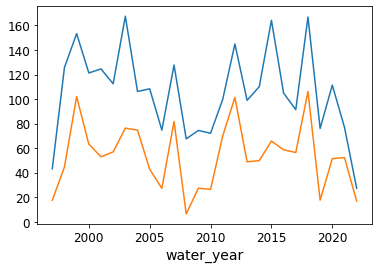

In [15]:
sublimation_daily_kguc = calc_penman_monteith(net_kguc_winter,0, winter_kguc_df['RELATIVE HUMIDITY'], winter_kguc_df['AIR TEMP'], winter_kguc_df['WIND SPEED']) 
sublimation_daily_kguc= sublimation_daily_kguc.mask(sublimation_daily_kguc  > 3).interpolate()
sublimation_daily_kguc.name = 'sublimation_mm'
sublimation_daily_kguc = pd.DataFrame(sublimation_daily_kguc)
sublimation_daily_kguc['water_year'] =  sublimation_daily_kguc.index.year.where(sublimation_daily_kguc.index.month < 10, sublimation_daily_kguc.index.year + 1) 

sublimation_daily_kguc['sublimation_mm'].groupby(sublimation_daily_kguc.water_year).sum().plot()
sublimation_kguc_totals.plot()

## Taylor Park Met Data 1988-2021

In [16]:
# Get data and filter appropriately
taylor_park_df = pd.read_csv('data/taylor_park_daily_met.txt',sep='\s+')
taylor_park_elev = 3201
taylor_park_df = taylor_park_df.set_index('Date')
taylor_park_df = taylor_park_df.replace(-9999,np.nan)
taylor_park_df.index = pd.to_datetime(taylor_park_df.index)
taylor_park_df['Year'] =  taylor_park_df.index.year.where(taylor_park_df.index.month < 10, taylor_park_df.index.year + 1)
taylor_park_df = taylor_park_df.rename(columns={'Year':'Water_Yr'})

# Calculated lw net and winterize the data
winter_taylor_park_df = taylor_park_df.loc[(taylor_park_df.index.month < 5) | (taylor_park_df.index.month == 12) ]
net_taylor_winter = calc_net_lw_radiation(temperature=winter_taylor_park_df['AveT'], 
                      relative_humidity=winter_taylor_park_df['AveRH'],
                      elevation=taylor_park_elev
                        )


# I should explore this method more, but it is better than the function I built based off of [Wang 2017]

In [17]:
sublimation_taylor_pm = pyet.pm(tmean=winter_taylor_park_df['AveT'],
        tmax=winter_taylor_park_df['MaxT'],
        tmin=winter_taylor_park_df['MinT'],
        rhmax=winter_taylor_park_df['MaxRH'],
        rhmin=winter_taylor_park_df['MinRH'],
        wind=winter_taylor_park_df['WSpd'],
        rh=winter_taylor_park_df['AveRH'],
        rn=net_taylor_winter*3600*24/1e6 ,
        elevation=taylor_park_elev,
        r_l=0,
        r_s=0,
        a_sh=0.5,
        ra_method=1)
sublimation_taylor_pm_df = sublimation_taylor_pm.to_frame(name='sublimation_mm')
sublimation_taylor_pm_df['water_year'] =  sublimation_taylor_pm_df.index.year.where(sublimation_taylor_pm_df.index.month < 10, sublimation_taylor_pm_df.index.year + 1)
sublimation_taylor_totals = sublimation_taylor_pm_df['sublimation_mm'].groupby(sublimation_taylor_pm_df['water_year']).sum()
sublimation_taylor_totals.rename = 'sublimation'  
      

## Get Snotel or Snow Course Data

Compute estimated sublimation at Taylor Park

Pull daily snotel point data from 1991-2022 from Butte snotel station

In [18]:
snotel_point = SnotelPointData("380:CO:SNTL", "Butte")
butte_df = snotel_point.get_daily_data(
    datetime(1991, 1, 1), datetime(2021, 9, 30),
    [snotel_point.ALLOWED_VARIABLES.PRECIPITATION,
     snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM,
     snotel_point.ALLOWED_VARIABLES.SNOWDEPTH,
     snotel_point.ALLOWED_VARIABLES.SWE,
     snotel_point.ALLOWED_VARIABLES.TEMP]
)
butte_df = butte_df.droplevel(1)

# Add water year
butte_df['water_year'] =  butte_df.index.year.where(butte_df.index.month < 10, butte_df.index.year + 1)

# Get max swe
butte_max_swe_mm = butte_df['SWE'].groupby(butte_df.index.year).max()*25.4

Get Park Cone snotel data starting in 1991

In [19]:
snotel_point = SnotelPointData("680:CO:SNTL", "ParkCone")
park_cone_df = snotel_point.get_daily_data(
    datetime(1991, 10, 1), datetime(2021, 9, 30),
    [snotel_point.ALLOWED_VARIABLES.PRECIPITATION,
     snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM,
     snotel_point.ALLOWED_VARIABLES.SNOWDEPTH,
     snotel_point.ALLOWED_VARIABLES.SWE,
     snotel_point.ALLOWED_VARIABLES.TEMP]
)
park_cone_df = park_cone_df.droplevel(1)

# Get water year for Park Cone data
park_cone_df['water_year'] =  park_cone_df.index.year.where(park_cone_df.index.month < 10, park_cone_df.index.year + 1).astype(int)

# Calculate max swe
park_cone_max_swe_mm = park_cone_df['SWE'].groupby(park_cone_df.index.year).max()*25.4

In [20]:
park_cone_df.to_csv('../../../../UW/UW-22-23/park_cone_sntl_1991_2021.csv')

In [21]:
park_cone_apr1_swe_mm = park_cone_df.loc[(park_cone_df.index.month==4) & (park_cone_df.index.day==1)][['SWE','water_year']]
park_cone_apr1_swe_mm = park_cone_apr1_swe_mm['SWE'].groupby(park_cone_apr1_swe_mm.index.year).mean()*25.4

Get Crested Butte snow course data starting in 1936

In [22]:

snowcourse_point = SnotelPointData("07L01:CO:SNOW", "CrestedButte")
crested_butte_df = snowcourse_point.get_snow_course_data(datetime(1936,2,1),datetime(2021,5,1), [snowcourse_point.ALLOWED_VARIABLES.SWE]).droplevel(1)

# Get water year for Crested Butte data
crested_butte_df['water_year'] =  crested_butte_df.index.year.where(crested_butte_df.index.month < 10, crested_butte_df.index.year + 1).astype(int)

# Calculate max swe (mm)
crested_butte_max_swe_mm = crested_butte_df['SWE'].groupby(crested_butte_df.index.year).max()*25.4

# Fill in missing point with nearby snow course
crested_butte_max_swe_mm[2001]=13.3*25.4
crested_butte_max_swe_mm[2002]=9.0*25.4
crested_butte_max_swe_mm[2003]=15.3*25.4
crested_butte_max_swe_mm = crested_butte_max_swe_mm.sort_index()

Could not find timezone info for 07L01:CO:SNOW (CrestedButte)


## Discharge, Peak SWE and Sublimation Relationships
### Results using Butte Snotel and KGUC Sublimation

In [23]:
# USGS stream gaging sites
sites = {'Gunnison River':'09114500', 'East River':'09112500'}

In [24]:
sublimation_taylor_pre22 = sublimation_taylor_pm_df[sublimation_taylor_pm_df['water_year'] < 2022]
taylor_park_sublimation_ranks = sublimation_taylor_pre22['sublimation_mm'].groupby(sublimation_taylor_pre22['water_year']).sum().rank()

sublimation_kguc_pre22 = sublimation_kguc_pm_df[sublimation_kguc_pm_df['water_year'] < 2022]
kguc_sublimation_ranks = sublimation_kguc_pre22['sublimation_mm'].groupby(sublimation_kguc_pre22['water_year']).sum().rank()

### Results using Butte Max SWE and KGUC Sublimation (1997-2021)

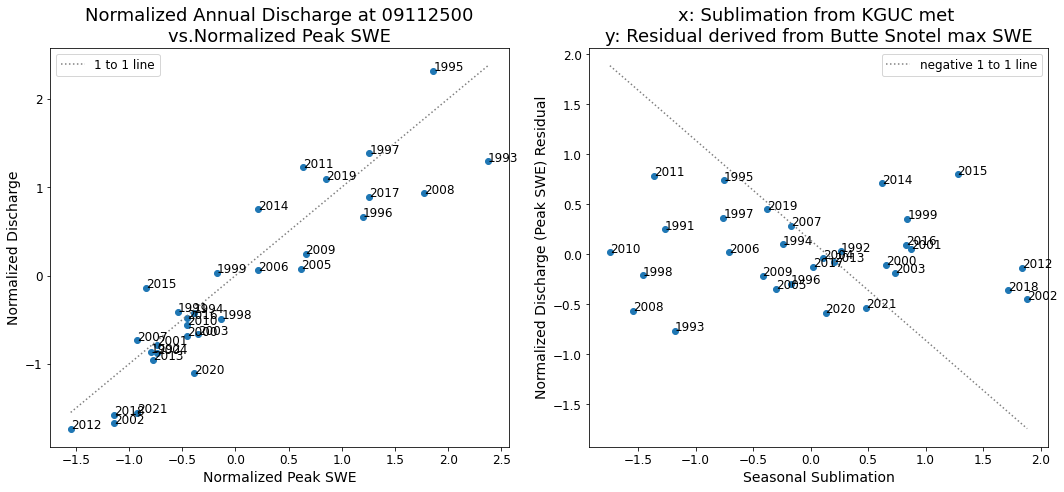

In [26]:
residual = plot_relationships(sites['East River'], 
                    butte_max_swe_mm, 
                    sublimation_taylor_totals, 
                    start_year=1991, 
                    labels={'title':'x: Sublimation from KGUC met \ny: Residual derived from Butte Snotel max SWE',
                            'xlabel':'Seasonal Sublimation'}, 
                    both=True, 
                    spring_only=False)

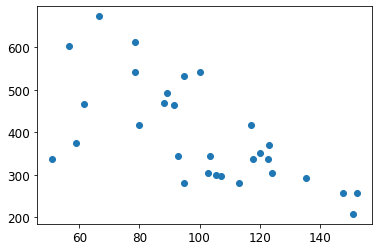

In [99]:
plt.scatter(sublimation_taylor_totals.loc[1992:2021],butte_max_swe_mm.loc[1992:2021])


NameError: name 'park_cone_df' is not defined

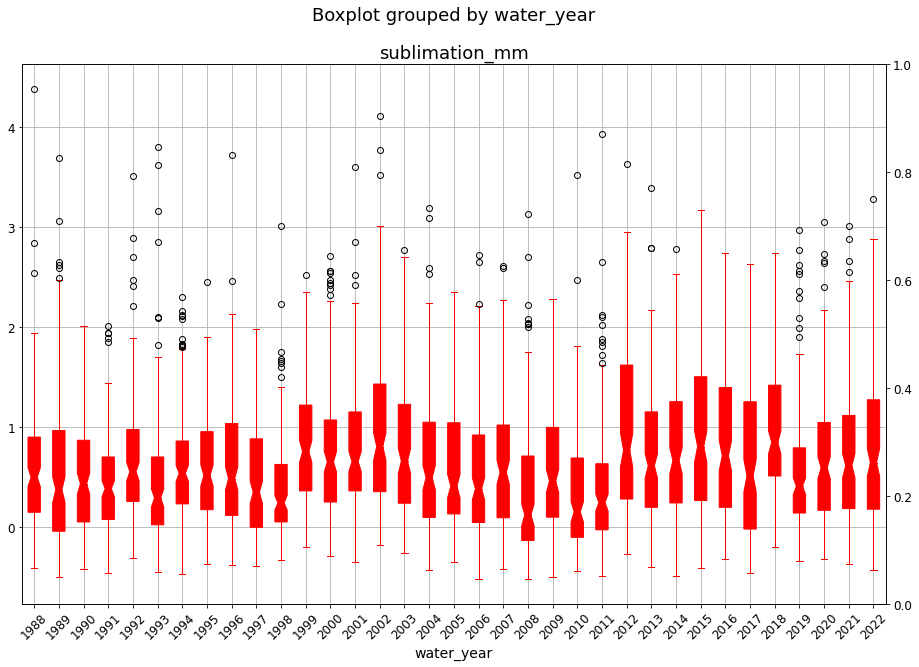

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sublimation_taylor_pm_df.boxplot("sublimation_mm", by='water_year', ax=ax, rot=45, color='red',notch=True, patch_artist=True, positions=np.arange(1987,2022,1))
ax2 = ax.twinx()
ax2.bar((25.4*park_cone_df['PRECIPITATON']).groupby(park_cone_df.water_year).sum().index,(25.4*park_cone_df['PRECIPITATON']).groupby(park_cone_df.water_year).sum().values, zorder=10,alpha=0.4, color='grey')
ax2.set_ylabel('Annual Precipitation (mm)')
ax.set_ylabel('Sublimation Rate (mm day$^{-1}$)')

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sublimation_taylor_pm_df.boxplot("sublimation_mm", by='water_year', ax=ax, rot=45, color='red',notch=True, patch_artist=True)
ax2 = ax.twinx()
(25.4*butte_df['PRECIPITATON']).groupby(butte_df.water_year).sum().plot.bar(ax=ax2, zorder=10,alpha=0.4, color='grey', label='Annual Precipitation')
ax2.set_ylabel('Annual Precipitation (mm)')
ax2.legend()
ax.set_ylabel('Sublimation Rate (mm day$^{-1}$)')


NameError: name 'plt' is not defined

In [1]:
residual = plot_relationships(sites['East River'], 
                    park_cone_max_swe_mm, 
                    sublimation_taylor_totals, 
                    start_year=1992, 
                    labels={'title':'x: Sublimation from Taylor Park met \ny: Residual derived from Park Cone Snotel max SWE',
                            'xlabel':'Seasonal Sublimation'}, 
                    both=True, 
                    spring_only=True)

NameError: name 'plot_relationships' is not defined

### Results using Crested Butte snow course and Taylor Park Sublimation (1988-2021)

In [101]:
residual = plot_relationships(sites['East River'], 
                    crested_butte_max_swe_mm, 
                    sublimation_taylor_totals, 
                    start_year=1989, 
                    labels={'title':'x: Sublimation from Taylor Park met \ny: Residual derived from CB Snowcourse max SWE',
                            'xlabel':'Seasonal Sublimation'}, 
                    both=True, 
                    spring_only=True)


NameError: name 'crested_butte_max_swe_mm' is not defined

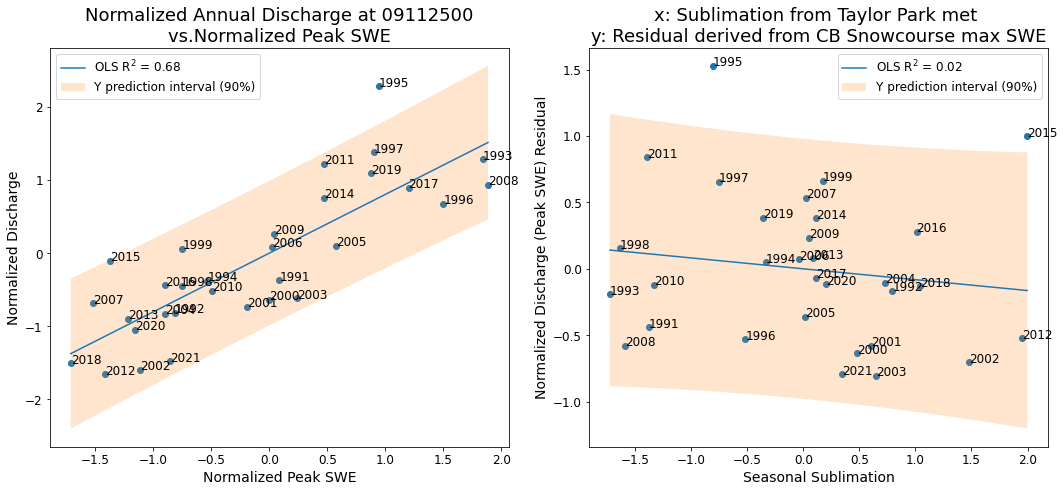

In [43]:
plot_relationships(sites['East River'], 
                    crested_butte_max_swe_mm, 
                    sublimation_taylor_totals, 
                    start_year=1991, 
                    labels={'title':'x: Sublimation from Taylor Park met \ny: Residual derived from CB Snowcourse max SWE',
                            'xlabel':'Seasonal Sublimation'}, 
                    both=True, 
                    spring_only=False)


### Results using Crested Butte snow course and Gunnison Sublimation (1997-2021)

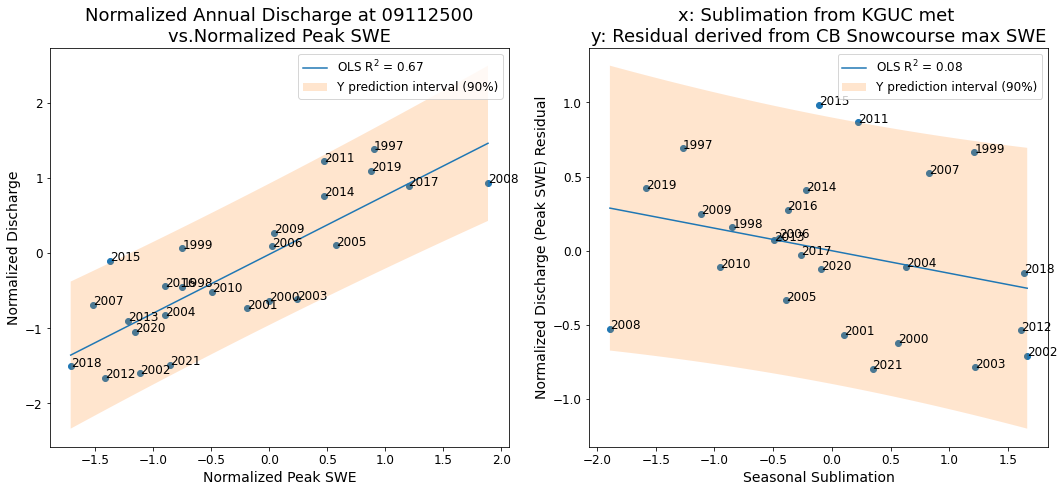

In [44]:
# sites = {'East River - Almont':'09112500', 'East River - Crested Butte':'09112200'}

plot_relationships(sites['East River'], 
                    crested_butte_max_swe_mm, 
                    sublimation_kguc_totals, 
                    start_year=1997, 
                    labels={'title':'x: Sublimation from KGUC met \ny: Residual derived from CB Snowcourse max SWE',
                            'xlabel':'Seasonal Sublimation'}, 
                    both=True, 
                    spring_only=False)

(-2.5, 2.5)

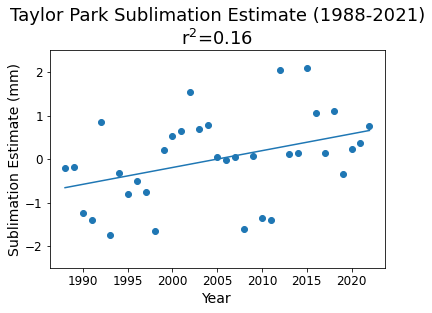

In [53]:
plt.scatter(sublimation_taylor_totals.index,normalize_data(sublimation_taylor_totals))

linregress_stats = stats.linregress(sublimation_taylor_totals.index,normalize_data(sublimation_taylor_totals))
plt.plot(sublimation_taylor_totals.index, linregress_stats[0]*sublimation_taylor_totals.index+linregress_stats[1])
plt.xlabel('Year')
plt.ylabel('Sublimation Estimate (mm)')
plt.title(f'Taylor Park Sublimation Estimate (1988-2021)\nr$^2$={round(linregress_stats[2]**2,2)}')
plt.ylim(-2.5,2.5)

### Add cumulative precipitation from peak swe as a first order predictor. Hypothesis is that one does not dominate a single year, it is a mix...

### Running the same analysis using the billy barr dataset going back to 2016

In [1111]:
filepath = r"C:\Users\dlhogan\OneDrive - UW\Documents\UW\UW-21-22\Q2-spring-quarter-2022\mtn-hydro\Scripts\billy-barr-all.dat"
bb_data = pd.read_table(filepath, delimiter=',', header=1).dropna()
units = bb_data.loc[0].to_list()
bb_data = bb_data.loc[1:]
col_renames = [col.replace(' ','') for col in bb_data.columns]
bb_data = bb_data.rename(columns=dict(zip(bb_data.columns,col_renames)))

bb_data['Datetime'] = pd.to_datetime(bb_data['Date']+' '+bb_data['Time'], format='%Y%m%d %H:%M')
bb_data = bb_data.set_index('Datetime')
bb_data_ma = bb_data[~bb_data.isin(['M',-9999.])]

bb_daily_ma = bb_data_ma.groupby(bb_data_ma.index.date).mean()
bb_daily_ma.index = pd.to_datetime(bb_daily_ma.index)

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_32944\1597281791.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  bb_data = pd.read_table(filepath, delimiter=',', header=1).dropna()
C:\Users\dlhogan\AppData\Local\Temp\ipykernel_32944\1597281791.py:12: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  bb_daily_ma = bb_data_ma.groupby(bb_data_ma.index.date).mean()


In [ ]:
# Calculated lw net and winterize the data
winter_bb_data = bb_daily_ma.loc[bb_daily_ma.index.month < 5 | ((bb_daily_ma.index.month == 12) & (bb_daily_ma.index.day > 1)) ]
net_bb_winter = calc_net_lw_radiation(temperature=(5/9)*(winter_bb_data['AvAir'].astype(float)-32), 
                      relative_humidity=winter_bb_data['Rel'].astype(float),
                      elevation=2890
                        )


In [ ]:
cols = []
count = 1
for column in winter_bb_data.columns:
    if column == 'Wind':
        cols.append(f'Wind_{count}')
        count+=1
        continue
    cols.append(column)
winter_bb_data.columns = cols

In [1086]:
sublimation_bb_pm = pyet.pm(tmean=(5/9)*(winter_bb_data['AvAir'].astype(float)-32),
        tmax=(winter_bb_data['MxAir'].astype(float)-32)*(5/9),
        tmin=(winter_bb_data['MnAir'].astype(float)-32)*(5/9),
        rhmax=winter_bb_data['MxRel'].astype(float),
        rhmin=winter_bb_data['MnRel'].astype(float),
        wind=winter_bb_data['Wind_1'].astype(float),
        rh=winter_bb_data['Rel'].astype(float),
        rn=net_bb_winter*3600*24/1e6 ,
        elevation=2890)
sublimation_bb_pm_df = sublimation_bb_pm.to_frame(name='sublimation_mm')
sublimation_bb_pm_df['water_year'] =  sublimation_bb_pm_df.index.year.where(sublimation_bb_pm_df.index.month < 10, sublimation_bb_pm_df.index.year + 1)
sublimation_bb_totals = sublimation_bb_pm_df['sublimation_mm'].groupby(sublimation_bb_pm_df['water_year']).sum()
sublimation_bb_totals.rename = 'sublimation'     


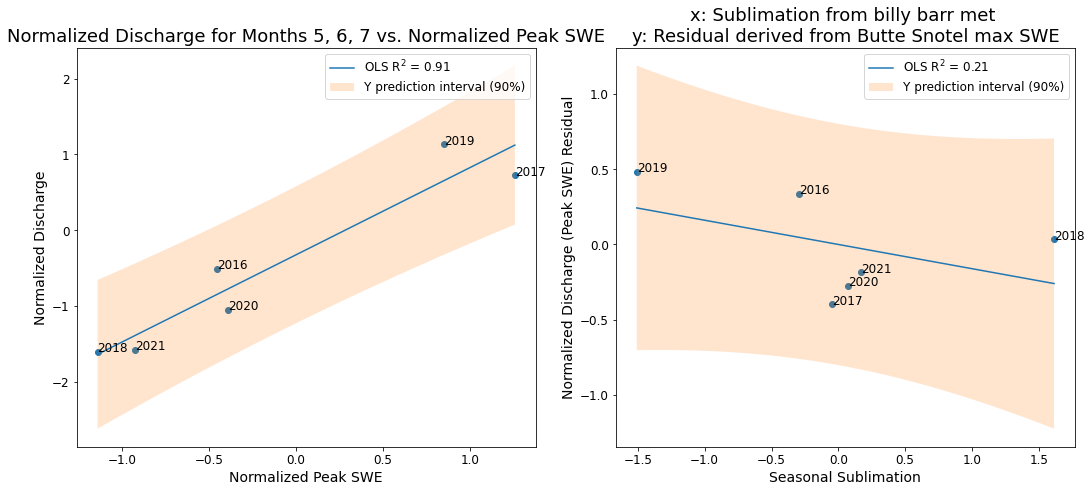

In [1205]:
sites = {'East River - Almont':'09112500', 'East River - Crested Butte':'09112200'}

# sites = {'East River - Almont':'09112500', 'East River - Crested Butte':'09112200'}

plot_relationships(sites['East River - Almont'], 
                    butte_max_swe_mm, 
                    sublimation_kguc_totals, 
                    start_year=2016, 
                    labels={'title':'x: Sublimation from billy barr met \ny: Residual derived from Butte Snotel max SWE',
                            'xlabel':'Seasonal Sublimation'}, 
                    both=True, 
                    spring_only=True)


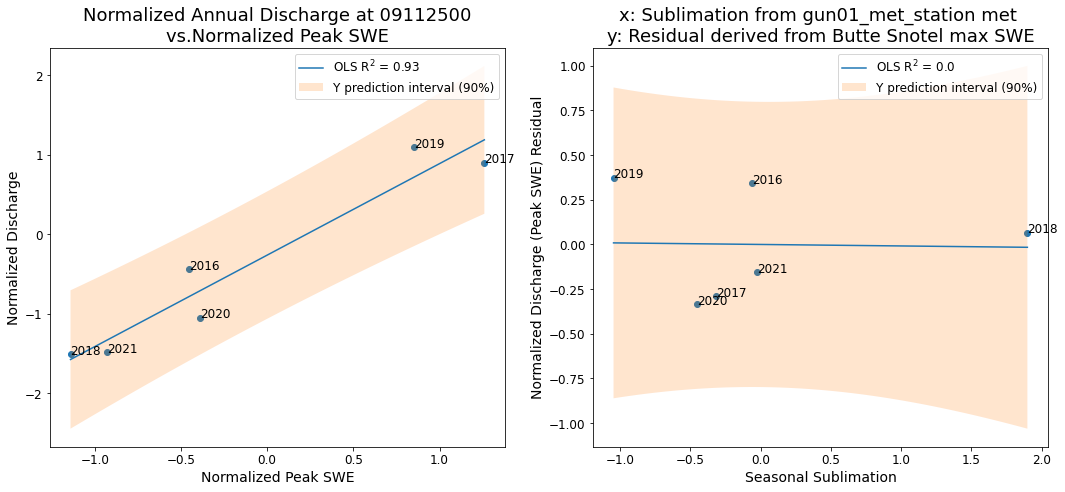

In [1207]:
sites = {'East River - Almont':'09112500', 'East River - Crested Butte':'09112200'}

plot_relationships(sites['East River - Almont'], 
                    butte_max_swe_mm, 
                    normalize_data(winter_et_gun01), 
                    start_year=2016, 
                    labels={'title':'x: Sublimation from gun01_met_station met \ny: Residual derived from Butte Snotel max SWE',
                            'xlabel':'Seasonal Sublimation'}, 
                    both=True, 
                    spring_only=False)

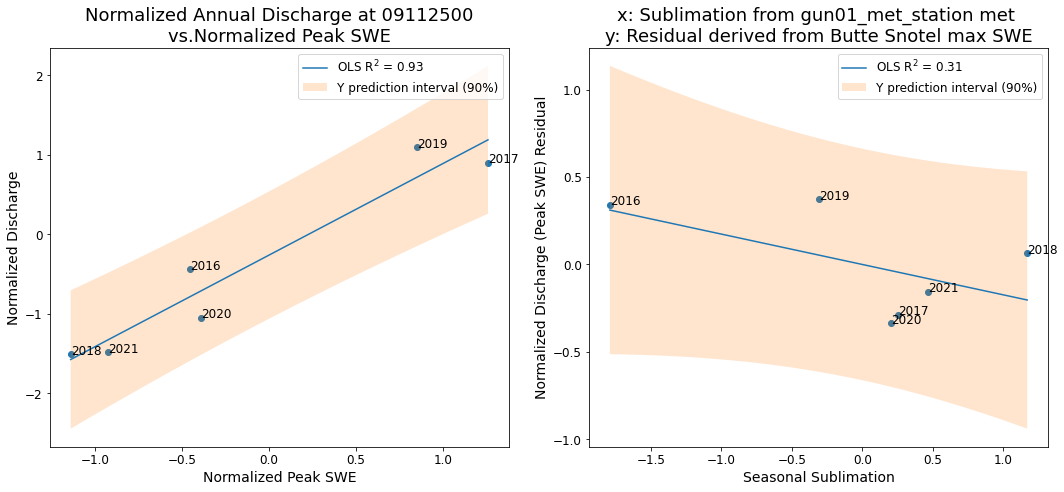

In [1208]:
sites = {'East River - Almont':'09112500', 'East River - Crested Butte':'09112200'}
plot_relationships(sites['East River - Almont'], 
                    butte_max_swe_mm, 
                    normalize_data(summer_et_gun01), 
                    start_year=2016, 
                    labels={'title':'x: Sublimation from gun01_met_station met \ny: Residual derived from Butte Snotel max SWE',
                            'xlabel':'Seasonal Sublimation'}, 
                    both=True, 
                    spring_only=False)

## Here I look into a couple different parameters that may account for more variability in accounting for the snow water gap

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_27960\3378782318.py:5: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  tmp = butte_df[butte_df.index.year == year].loc[melt_dates.loc[year].date():dt.date(year,9,1)]['PRECIPITATON']
C:\Users\dlhogan\AppData\Local\Temp\ipykernel_27960\3378782318.py:5: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  tmp = butte_df[butte_df.index.year == year].loc[melt_dates.loc[year].date():dt.date(year,9,1)]['PRECIPITATON']
C:\Users\dlhogan\AppData\Local\Temp\ipykernel_27960\3378782318.py:5: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  tmp = butte_df[butt

datetime
1993   -0.212464
1994    0.028225
1995    1.508705
1996   -0.548891
1997    0.634938
1998    0.134338
1999    0.642291
2000   -0.658057
2001   -0.601512
2002   -0.725084
2003   -0.827145
2004   -0.125895
2005   -0.382592
2006    0.049395
2007    0.513841
2008   -0.599201
2009    0.211461
2010   -0.140358
2011    0.820573
2012   -0.546037
2013    0.058255
2014    0.360749
2015    0.975234
2016    0.258475
2017   -0.086053
2018   -0.153669
2019    0.365773
2020   -0.139092
2021   -0.816203
dtype: float64

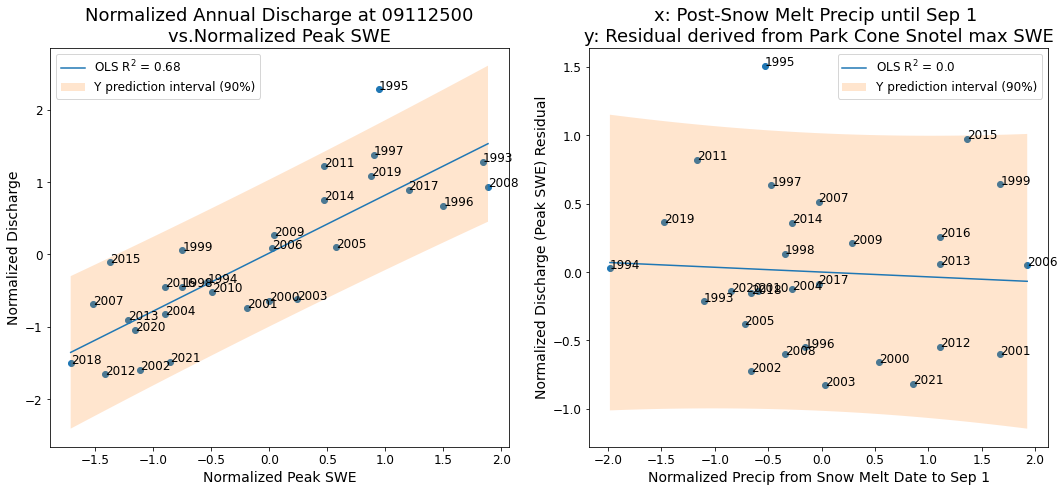

In [54]:

sites = {'Gunnison River':'09114500', 'East River':'09112500'}
melt_dates = butte_df['SWE'].groupby(butte_df.index.year).idxmin().drop([1991])
post_snow_melt_precip = []
for year in melt_dates.index:
    tmp = butte_df[butte_df.index.year == year].loc[melt_dates.loc[year].date():dt.date(year,9,1)]['PRECIPITATON']
    post_snow_melt_precip.append(tmp.sum())
post_snow_precip_df = pd.Series(post_snow_melt_precip, index=melt_dates.index)

plot_relationships(sites['East River'], 
                    crested_butte_max_swe_mm, 
                    post_snow_precip_df, 
                    start_year=1993, 
                    labels={'title':'x: Post-Snow Melt Precip until Sep 1 \ny: Residual derived from Park Cone Snotel max SWE',
                            'xlabel':'Normalized Precip from Snow Melt Date to Sep 1'}, 
                    both=True, 
                    spring_only=False)

### Current years' precipitation anomaly

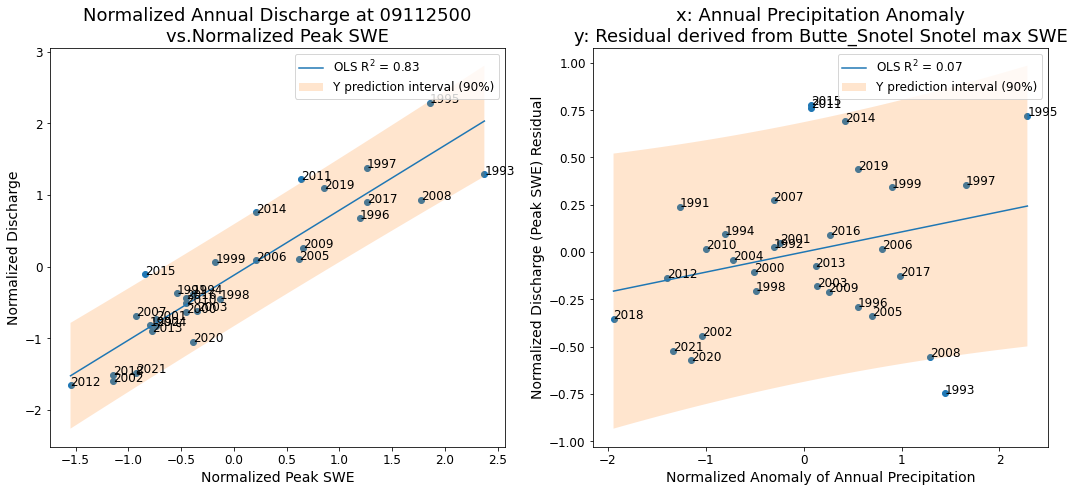

In [1215]:
annual_precip = butte_df['PRECIPITATON'].groupby(butte_df['water_year']).sum()
annual_precip_norm_anom =  normalize_data(annual_precip)

plot_relationships(sites['East River'], 
                    butte_max_swe_mm, 
                    annual_precip_norm_anom, 
                    start_year=1991, 
                    labels={'title':'x: Annual Precipitation Anomaly\ny: Residual derived from Butte_Snotel Snotel max SWE',
                            'xlabel':'Normalized Anomaly of Annual Precipitation'}, 
                    both=True, 
                    spring_only=False)                                                

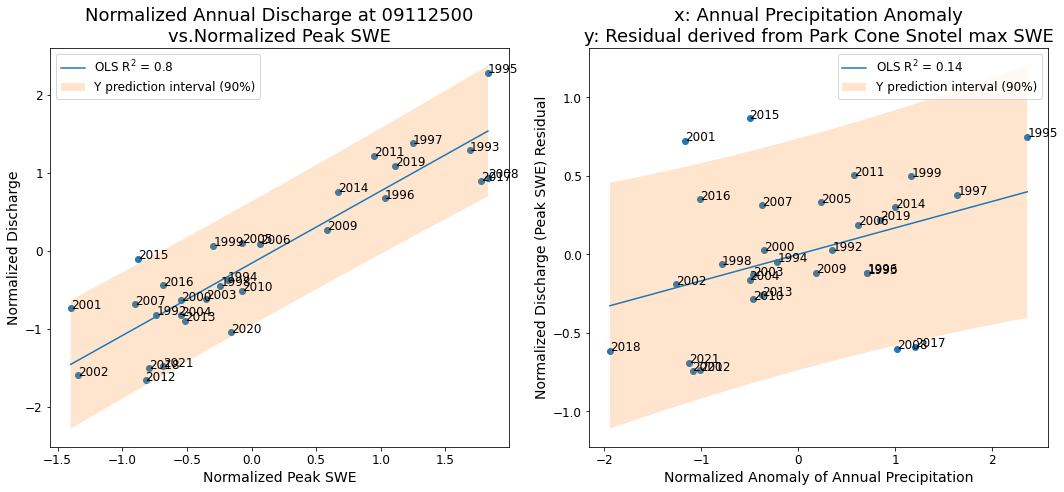

In [57]:
annual_precip = park_cone_df['PRECIPITATON'].groupby(park_cone_df['water_year']).sum()
annual_precip_norm_anom =  normalize_data(annual_precip)

residual = plot_relationships(sites['East River'], 
                    park_cone_max_swe_mm, 
                    annual_precip_norm_anom, 
                    start_year=1992, 
                    labels={'title':'x: Annual Precipitation Anomaly\ny: Residual derived from Park Cone Snotel max SWE',
                            'xlabel':'Normalized Anomaly of Annual Precipitation'}, 
                    both=True, 
                    spring_only=False)     

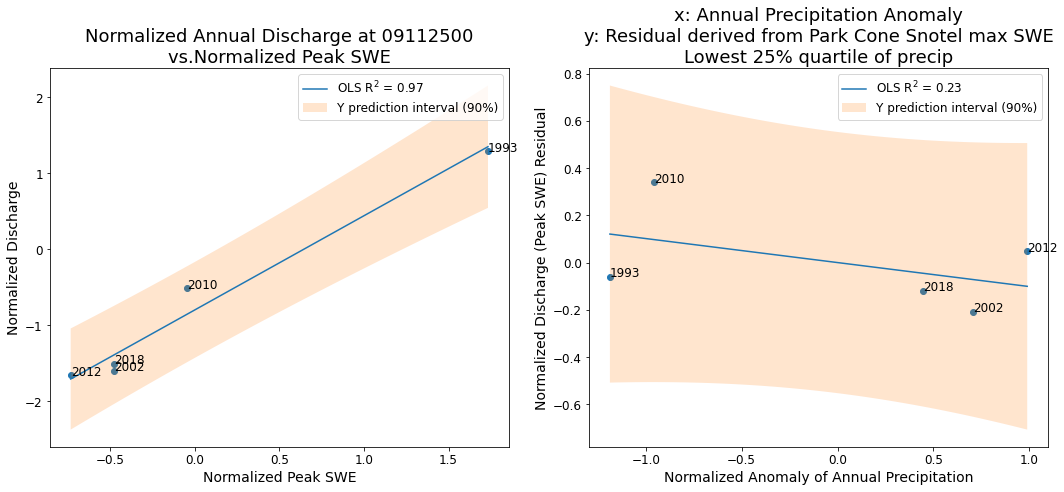

In [125]:
# USGS stream gaging sites
annual_precip = gunnison_df['pcpn'].groupby(gunnison_df['water_year']).sum()
precip_quartile_25 = annual_precip[annual_precip < np.percentile(annual_precip,25)].index.drop(2022)

residual = plot_relationships(sites['East River'], 
                    butte_max_swe_mm.loc[precip_quartile_25[precip_quartile_25>1992]], 
                    sublimation_taylor_totals.loc[precip_quartile_25[precip_quartile_25>1992]], 
                    start_year=1992, 
                    labels={'title':'x: Annual Precipitation Anomaly\ny: Residual derived from Park Cone Snotel max SWE\nLowest 25% quartile of precip',
                            'xlabel':'Normalized Anomaly of Annual Precipitation'}, 
                    both=True, 
                    spring_only=False)     

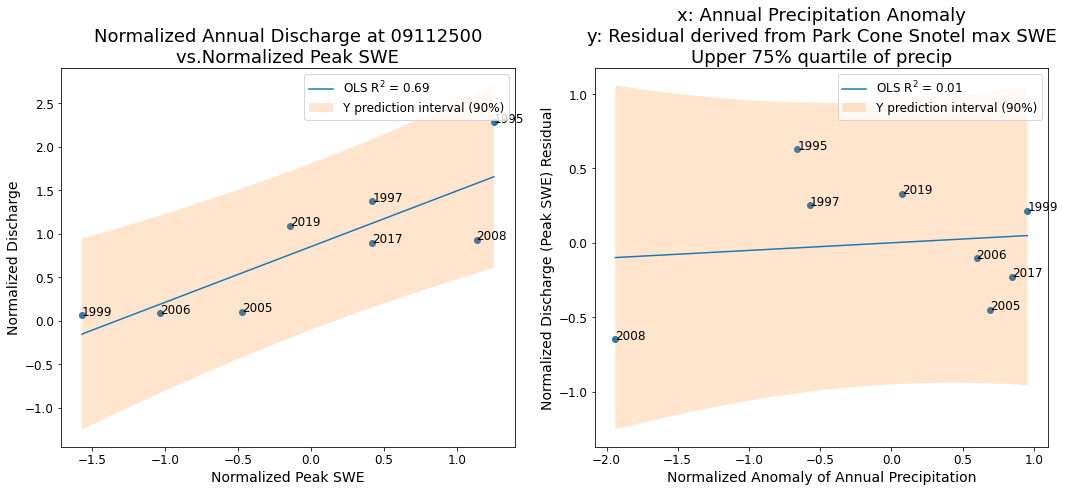

In [126]:
# Precipitation quartile range filter
annual_precip = gunnison_df['pcpn'].groupby(gunnison_df['water_year']).sum()
precip_quartile_75 = annual_precip[annual_precip > np.percentile(annual_precip,75)].index

residual = plot_relationships(sites['East River'], 
                    butte_max_swe_mm.loc[precip_quartile_75[precip_quartile_75>1992]], 
                    sublimation_taylor_totals.loc[precip_quartile_75[precip_quartile_75>1992]], 
                    start_year=1992, 
                    labels={'title':'x: Annual Precipitation Anomaly\ny: Residual derived from Park Cone Snotel max SWE\nUpper 75% quartile of precip',
                            'xlabel':'Normalized Anomaly of Annual Precipitation'}, 
                    both=True, 
                    spring_only=False)     

### Previous Summer/Fall Precipitation Anomaly

water_year
1992    0.249971
1993   -0.082683
2002   -0.266222
2010    0.289930
2012   -0.014879
2018   -0.176118
dtype: float64

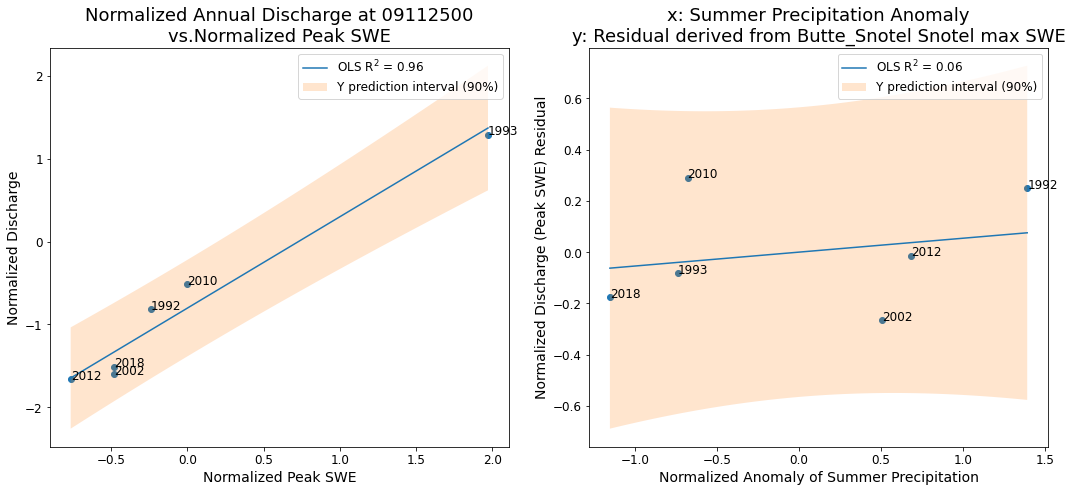

In [95]:
# USGS stream gaging sites
annual_precip = gunnison_df['pcpn'].groupby(gunnison_df['water_year']).sum()
precip_quartile_25 = annual_precip[annual_precip < np.percentile(annual_precip,25)].index.drop(2022)

sites = {'Gunnison River':'09114500', 'East River':'09112500'}
non_snow_precip = butte_df.loc[(butte_df.index.month>5) & (butte_df.index.month<10)]
summer_precip = non_snow_precip['PRECIPITATON'].groupby(non_snow_precip['water_year']).sum()
summer_precip_norm_anom = normalize_data(summer_precip)

plot_relationships(sites['East River'], 
                    butte_max_swe_mm.loc[precip_quartile_75[precip_quartile_75>1991]], 
                    summer_precip_norm_anom.loc[precip_quartile_75[precip_quartile_75>1991]], 
                    start_year=1991, 
                    labels={'title':'x: Summer Precipitation Anomaly\ny: Residual derived from Butte_Snotel Snotel max SWE',
                            'xlabel':'Normalized Anomaly of Summer Precipitation'}, 
                    both=True, 
                    spring_only=False)                                                 

datetime
1992    0.025327
1993   -0.121034
1994   -0.048660
1995    0.750247
1996   -0.118471
1997    0.379373
1998   -0.063275
1999    0.495847
2000    0.027397
2001    0.722351
2002   -0.191546
2003   -0.131695
2004   -0.162408
2005    0.332048
2006    0.189182
2007    0.311425
2008   -0.601314
2009   -0.117666
2010   -0.285201
2011    0.502643
2012   -0.739257
2013   -0.261687
2014    0.298663
2015    0.867562
2016    0.349885
2017   -0.587066
2018   -0.613130
2019    0.220939
2020   -0.740062
2021   -0.690414
dtype: float64

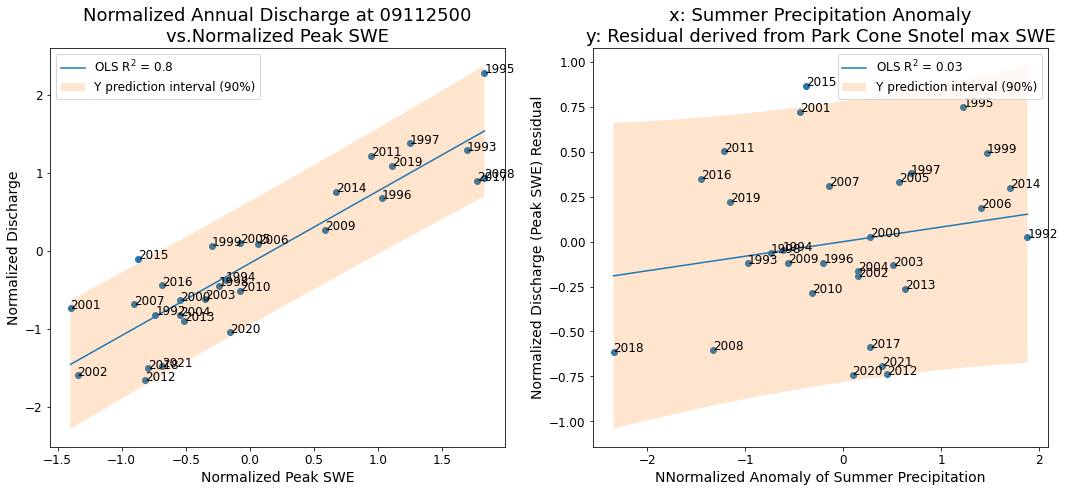

In [92]:
# USGS stream gaging sites
sites = {'Gunnison River':'09114500', 'East River':'09112500'}
non_snow_precip = park_cone_df.loc[(park_cone_df.index.month>5) & (park_cone_df.index.month<10)]
annual_precip = non_snow_precip['PRECIPITATON'].groupby(non_snow_precip['water_year']).sum()
annual_precip_norm_anom = normalize_data(annual_precip)

plot_relationships(sites['East River'], 
                    park_cone_max_swe_mm, 
                    annual_precip_norm_anom, 
                    start_year=1992, 
                    labels={'title':'x: Summer Precipitation Anomaly\ny: Residual derived from Park Cone Snotel max SWE',
                            'xlabel':'NNormalized Anomaly of Summer Precipitation'}, 
                    both=True, 
                    spring_only=False)             

                    

### Winter Precipitation Anomaly

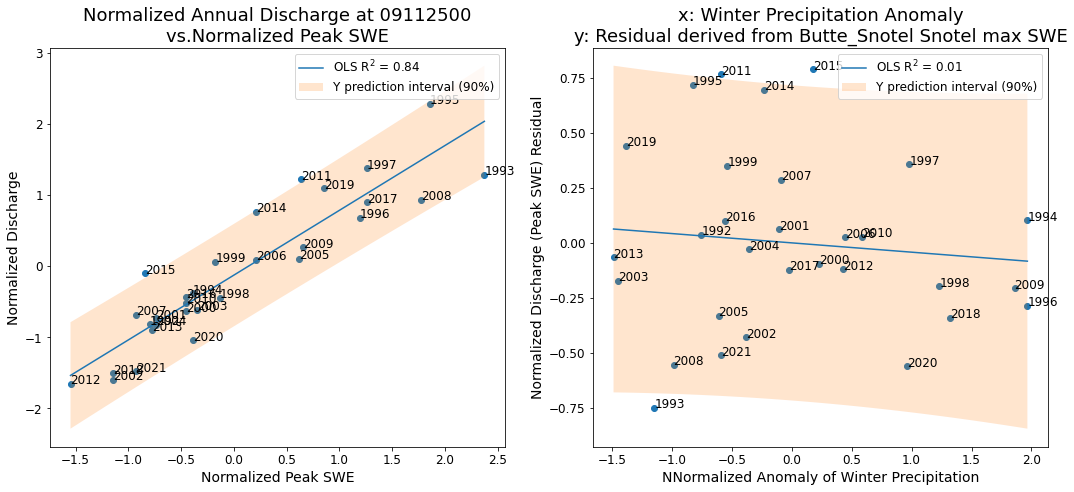

In [1222]:
snowy_precip = butte_df.loc[(butte_df.index.month<6) | (butte_df.index.month>11)]
annual_precip = snowy_precip['PRECIPITATON'].groupby(snowy_precip['water_year']).sum()
annual_precip_norm_anom = normalize_data(annual_precip)
annual_precip_norm_anom.index = annual_precip_norm_anom.index+1

plot_relationships(sites['East River'], 
                    butte_max_swe_mm, 
                    annual_precip_norm_anom, 
                    start_year=1992, 
                    labels={'title':'x: Winter Precipitation Anomaly\ny: Residual derived from Butte_Snotel Snotel max SWE',
                            'xlabel':'NNormalized Anomaly of Winter Precipitation'}, 
                    both=True, 
                    spring_only=False)                                                      

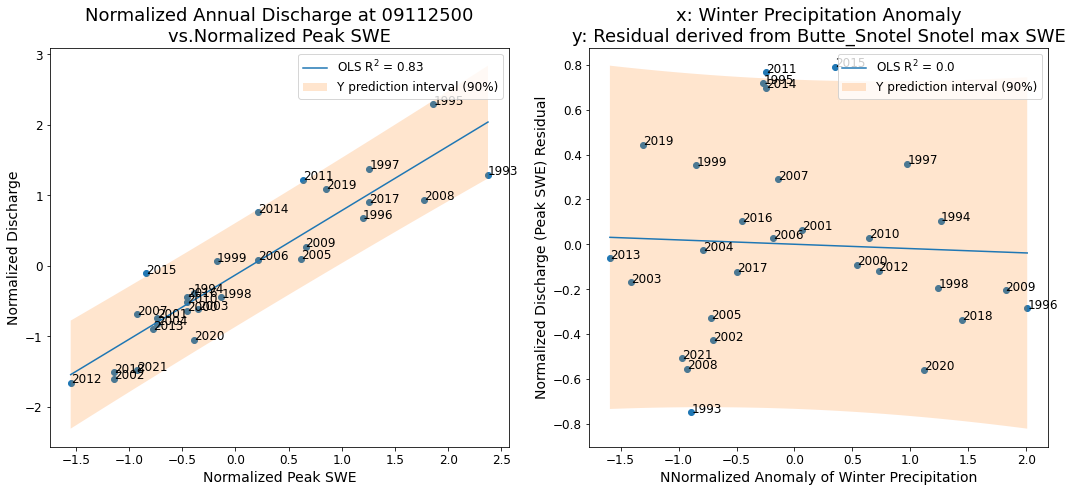

In [1224]:
snowy_precip = park_cone_df.loc[(park_cone_df.index.month<6) | (park_cone_df.index.month>11)]
annual_precip = snowy_precip['PRECIPITATON'].groupby(snowy_precip['water_year']).sum()
annual_precip_norm_anom = normalize_data(annual_precip)
annual_precip_norm_anom.index = annual_precip_norm_anom.index+1

plot_relationships(sites['East River'], 
                    butte_max_swe_mm, 
                    annual_precip_norm_anom, 
                    start_year=1993, 
                    labels={'title':'x: Winter Precipitation Anomaly\ny: Residual derived from Butte_Snotel Snotel max SWE',
                            'xlabel':'NNormalized Anomaly of Winter Precipitation'}, 
                    both=True, 
                    spring_only=False)     

### Previous 2-year average anomaly of summer precipitation

water_year
1995    0.569553
1997    0.259223
1999    0.317801
2005   -0.378758
2006   -0.326090
2008   -0.540440
2017   -0.376309
2019    0.475020
dtype: float64

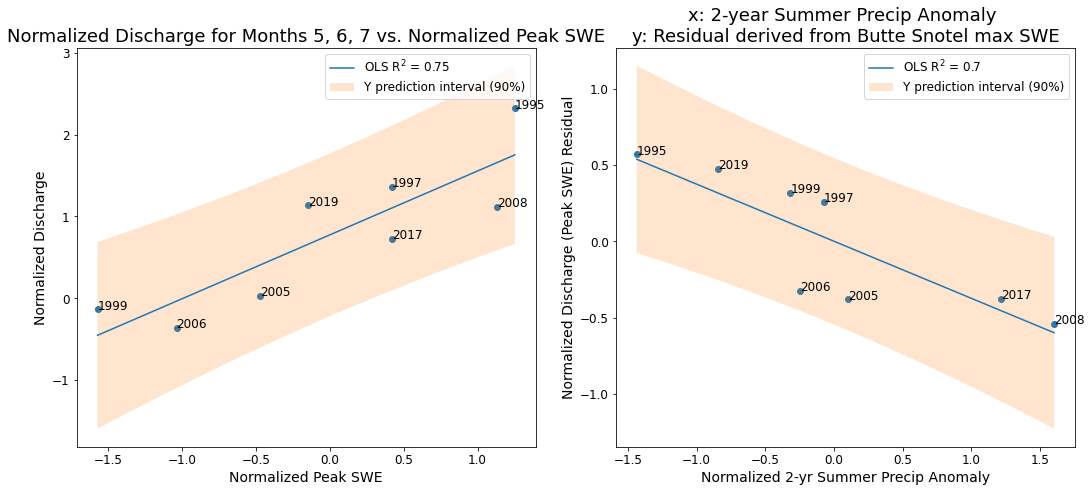

In [123]:
annual_precip = butte_df.loc[(butte_df.index.month>5) & (butte_df.index.month<10)]['PRECIPITATON'].groupby(butte_df.loc[(butte_df.index.month>5) & (butte_df.index.month<10)]['water_year']).sum()
annual_precip_norm_anom = normalize_data(annual_precip)

tmp = []
yr = []
for i,val in enumerate(annual_precip_norm_anom):
    if i < len(annual_precip_norm_anom)-1:
        tmp.append(np.mean([val,annual_precip_norm_anom.iloc[i+1]]))
        yr.append(annual_precip_norm_anom.index[i]+2)

previous_2yr_anomaly = pd.Series(data=tmp,index=yr)

# Precipitation quartile range filter
annual_precip = gunnison_df['pcpn'].groupby(gunnison_df['water_year']).sum()
precip_quartile_75 = annual_precip[annual_precip > np.percentile(annual_precip,75)].index

plot_relationships(sites['East River'],
                   butte_max_swe_mm.loc[precip_quartile_75[precip_quartile_75>1994]],
                   previous_2yr_anomaly.loc[precip_quartile_75[precip_quartile_75>1994]],
                   start_year=1994, 
                    labels={'title':'x: 2-year Summer Precip Anomaly \ny: Residual derived from Butte Snotel max SWE',
                            'xlabel':'Normalized 2-yr Summer Precip Anomaly'}, 
                    both=True, 
                    spring_only=True)

In the lowest quartile range of annual precipitation, SWE is a good predictor for the average annual stream flow. Adding in more higher values for summer precip pushes the residual to be larger

In the highest quartile range of precipiation anomaly, the larger the summer precip anomaly, the more important this summer precipitation is for the discharge of the river. If the summer precipitation is small, the snowpack dominates the prediction and overestimates streamflow, but in years with below average 

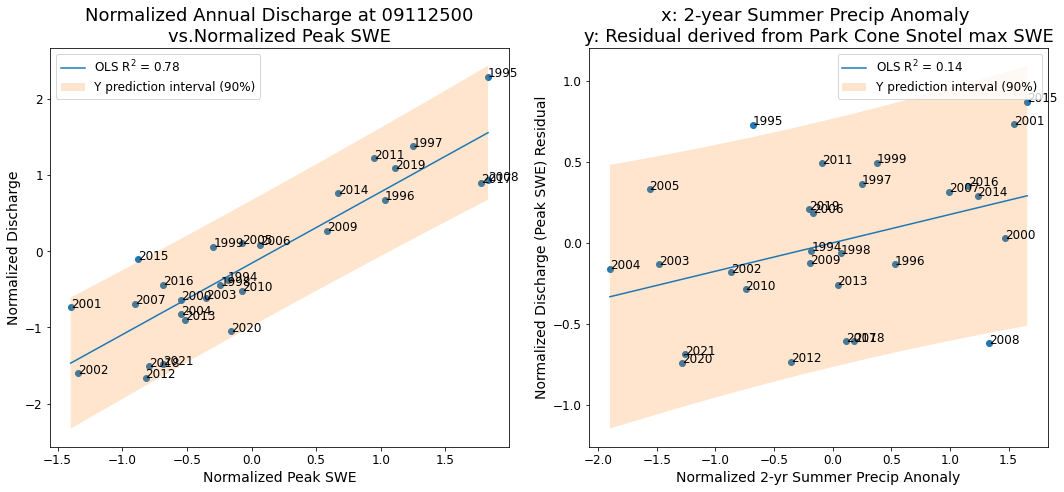

In [1231]:

annual_precip = taylor_park_df.loc[(taylor_park_df.index.month>5) & (taylor_park_df.index.month<10)]['pcpn'].groupby(taylor_park_df.loc[(taylor_park_df.index.month>5) & (taylor_park_df.index.month<10)].index.year).sum()
annual_precip_norm_anom = normalize_data(annual_precip)

tmp = []
yr = []
for i,val in enumerate(annual_precip):
    if i < len(annual_precip)-1:
        tmp.append(np.mean([val,annual_precip.iloc[i+1]]))
        yr.append(annual_precip.index[i]+2)

previous_2yr_anomaly = pd.Series(data=tmp,index=yr)
previous_2yr_anomaly = normalize_data(previous_2yr_anomaly)


plot_relationships(sites['East River'],
                   park_cone_max_swe_mm,
                   previous_2yr_anomaly,
                   start_year=1994, 
                    labels={'title':'x: 2-year Summer Precip Anomaly \ny: Residual derived from Park Cone Snotel max SWE',
                            'xlabel':'Normalized 2-yr Summer Precip Anonaly'}, 
                    both=True, 
                    spring_only=False)


### Previous 3-years precipiation anomaly

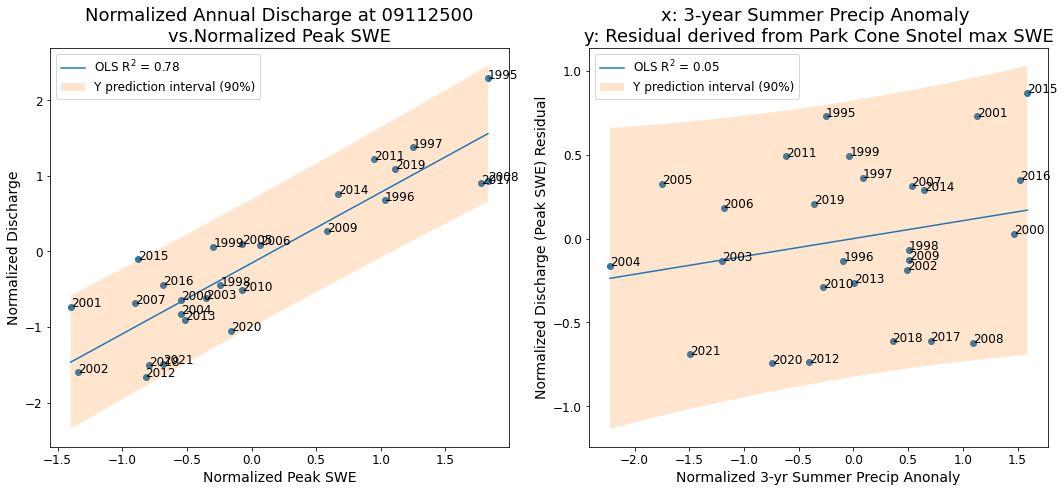

In [1232]:
tmp = []
yr = []
for i,val in enumerate(annual_precip_norm_anom):
    if i < len(annual_precip_norm_anom)-2:
        tmp.append(np.mean([val,annual_precip_norm_anom.iloc[i+1],annual_precip_norm_anom.iloc[i+2]]))
        yr.append(annual_precip_norm_anom.index[i]+3)

previous_3yr_anomaly = pd.Series(data=tmp,index=yr)

plot_relationships(sites['East River'],
                   park_cone_max_swe_mm,
                   previous_3yr_anomaly,
                   start_year=1995, 
                    labels={'title':'x: 3-year Summer Precip Anomaly \ny: Residual derived from Park Cone Snotel max SWE',
                            'xlabel':'Normalized 3-yr Summer Precip Anonaly'}, 
                    both=True, 
                    spring_only=False)                                                

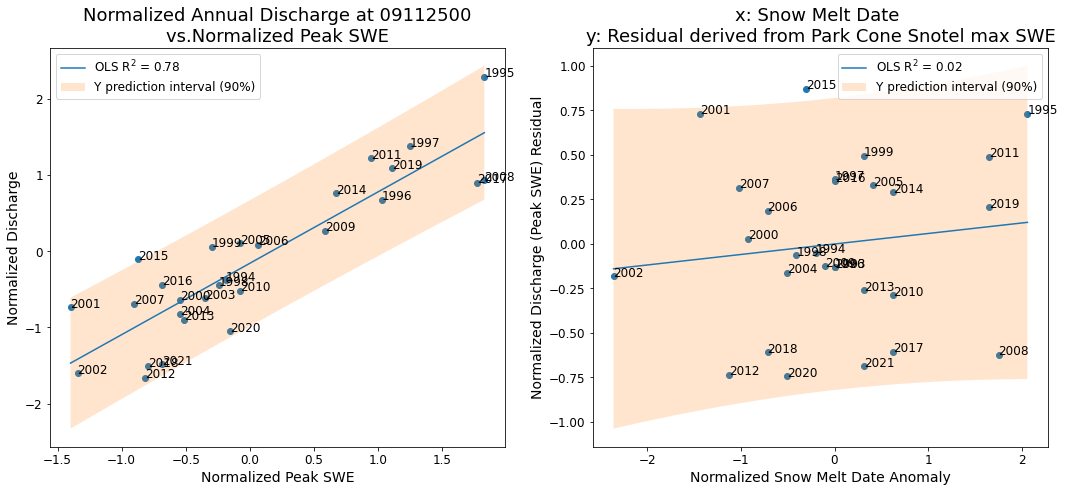

In [1233]:
melt_dates = park_cone_df['SWE'].groupby(park_cone_df.index.year).idxmin()
melt_dates = pd.Series([date.timetuple().tm_yday for date in melt_dates], index=melt_dates.index)


plot_relationships(sites['East River'],
                   park_cone_max_swe_mm,
                   melt_dates,
                   start_year=1994, 
                    labels={'title':'x: Snow Melt Date \ny: Residual derived from Park Cone Snotel max SWE',
                            'xlabel':'Normalized Snow Melt Date Anomaly'}, 
                    both=True, 
                    spring_only=False)

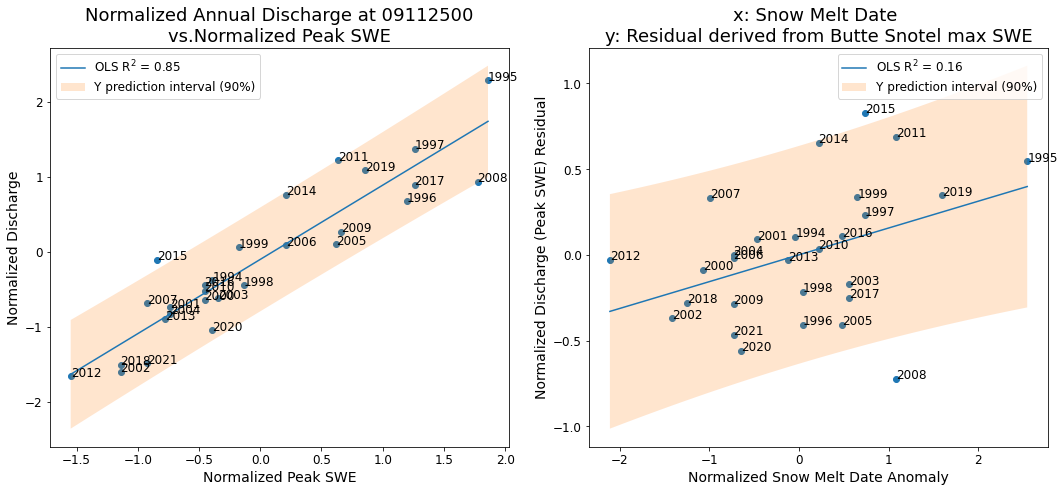

In [1235]:
melt_dates = butte_df['SWE'].groupby(butte_df.index.year).idxmin()
melt_dates = pd.Series([date.timetuple().tm_yday for date in melt_dates], index=melt_dates.index)


plot_relationships(sites['East River'],
                   butte_max_swe_mm,
                   melt_dates,
                   start_year=1994, 
                    labels={'title':'x: Snow Melt Date \ny: Residual derived from Butte Snotel max SWE',
                            'xlabel':'Normalized Snow Melt Date Anomaly'}, 
                    both=True, 
                    spring_only=False)

In [809]:
myFile=r"C:\Users\dlhogan\Downloads\soil_gridMET.nc"
sm_ds = xr.open_dataset(myFile, decode_times=False)

dates = []
start = dt.date(1900,1,1)

for day in sm_ds.time.to_numpy():
    delta = dt.timedelta(day)
    offset = start + delta
    dates.append(offset)
sm_ds['time'] = pd.to_datetime(dates)

sm_crested_butte = sm_ds.sel(lat=38.8697, lon=-106.9878, method='nearest')
sm_crested_butte_summer = sm_crested_butte.soil
sm_crested_butte_summer_mean = sm_crested_butte_summer.groupby(sm_crested_butte_summer['time.year']).mean()

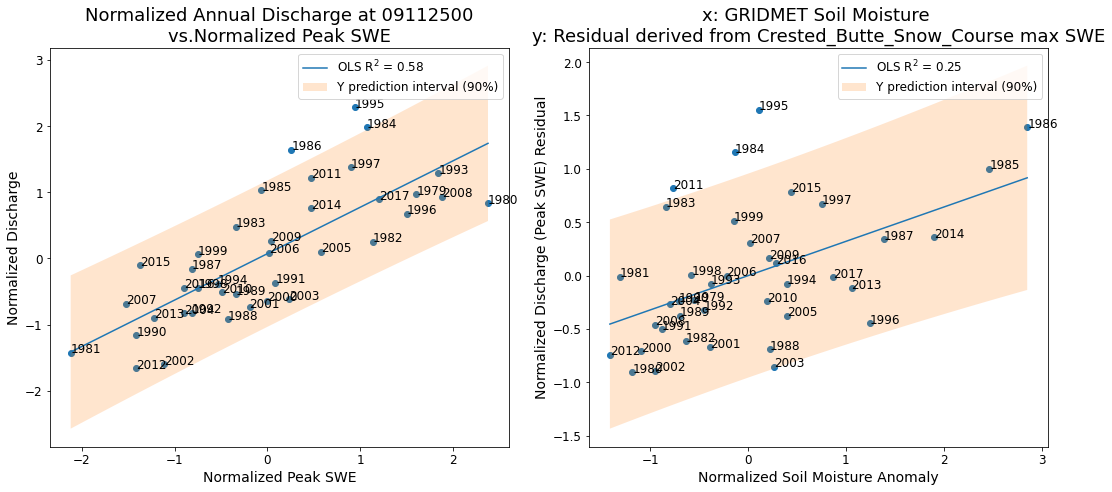

In [1238]:

plot_relationships(sites['East River'],
                   crested_butte_max_swe_mm,
                   normalize_data(sm_crested_butte_summer_mean.to_pandas()),
                   start_year=1979,
                   end_year=2017, 
                    labels={'title':'x: GRIDMET Soil Moisture \ny: Residual derived from Crested_Butte_Snow_Course max SWE',
                            'xlabel':'Normalized Soil Moisture Anomaly'}, 
                    both=True, 
                    spring_only=False)                                                

In [883]:
myFile = "http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_terraclimate_soil_1958_CurrentYear_GLOBE.nc"
sm_ds = xr.open_dataset(myFile).sel(lat=38.8697, lon=-106.9878, method='nearest')


<xarray.Dataset>
Dimensions:  (time: 768, crs: 1)
Coordinates:
  * crs      (crs) int16 3
    lon      float64 -107.0
    lat      float64 38.85
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2021-12-01
Data variables:
    soil     (time) float32 nan nan nan nan nan 37.9 ... 20.3 16.7 14.2 nan nan
Attributes: (12/49)
    method:                          These layers from TerraClimate were deri...
    title:                           TerraClimate: monthly climate and climat...
    summary:                         This archive contains a dataset of high-...
    keywords:                        WORLDCLIM,global,monthly, temperature,pr...
    id:                              Blank
    naming_authority:                edu.uidaho.nkn
    ...                              ...
    geospatial_vertical_resolution:  0.0
    geospatial_vertical_positive:    Up
    references:                      Abatzoglou, J.T., S.Z. Dobrowski, S.A. P...
    source:                          WorldClim v2.0 (2.5m), CRU Ts4.0, JRA-55
    version:                         v1.0
    Conventions:                     CF-1.6

# Next I'll look into a couple of different reanalysis datasets 

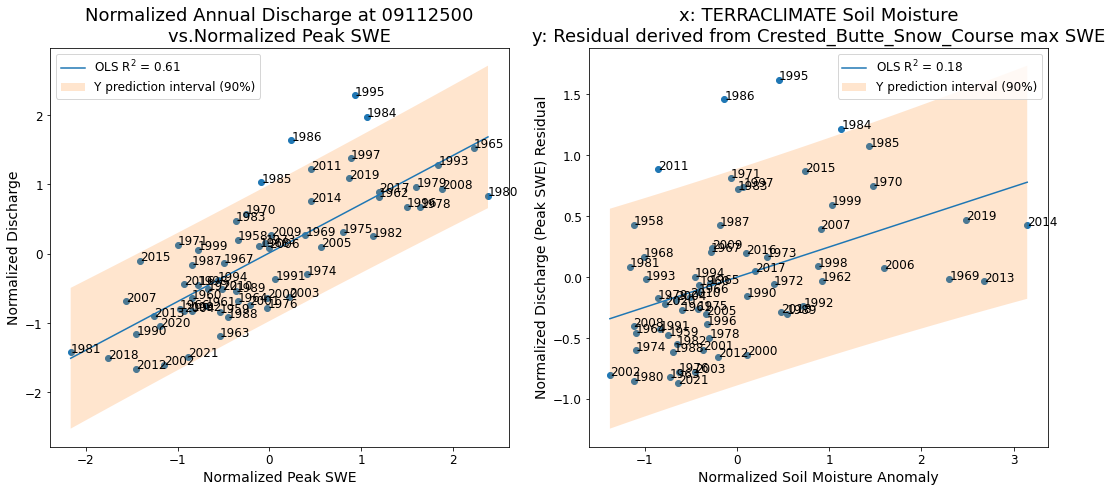

In [1240]:

annual_sm = sm_ds.soil.groupby(sm_ds['time.year']).mean().to_pandas()

plot_relationships(sites['East River'],
                   crested_butte_max_swe_mm[crested_butte_max_swe_mm.index!=1977],
                   normalize_data(annual_sm[annual_sm.index!=1977]),
                   start_year=1958,
                   end_year=2021, 
                    labels={'title':'x: TERRACLIMATE Soil Moisture\ny: Residual derived from Crested_Butte_Snow_Course max SWE',
                            'xlabel':'Normalized Soil Moisture Anomaly'}, 
                    both=True, 
                    spring_only=False)                                                  
                                                

## Get NCEP reanalysis data

In [402]:
# coords = (38.95615768432617, -106.98785400390625)
coords = (37.5,-107.5)
product_codes = ['air','rhum', 'uwnd','vwnd']

In [403]:
def ncep_reanalysis_dynamic_load(product, product_code, start_year, end_year, coords, first_yr_start_date=None, first_yr_end_date=None):
    
    # Connect to FTP server
    print('Connecting to FTP server...')
    ftp = ftplib.FTP('ftp2.psl.noaa.gov') # Connect to NOAA's FTP
    ftp.login() # Anonymous login

    ftp.cwd(f'./Datasets/ncep.reanalysis.dailyavgs/{product}/')

    # Collect files into list
    print('Connected and pulled files...')
    files = ftp.nlst()
    ftp.close()
    print('Closed FTP session...')

    # Separate out files that I'm interested in
    product_files = []
    years = np.arange(start_year, end_year+1,1).astype(str)
    
    for file in files:
        if (product_code in file) & (file[-7:-3] in years):
            product_files.append(file)

    datasets = []
    # Concatenate on year and filter out unncessary values if desired
    for file in product_files:
        print(f'Fetching {file}...')
        # used this as reference: https://towardsdatascience.com/an-efficient-way-to-read-data-from-the-web-directly-into-python-a526a0b4f4cb
        url = f'ftp://ftp2.psl.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/{product}/' + file
        req = urllib.request.Request(url)

        with urllib.request.urlopen(req) as resp:
            ds = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')
            
            print(f'Filtering {file}...')
            # Transform coordiantes
            ds.coords['lon'] = ds.coords['lon'] - 180
            # Filter to western US
            ds = ds.sel(lat=coords[0], lon=coords[1], method='nearest')
            
            # If provided, remove start year's dates
            if (first_yr_start_date) and (first_yr_end_date) and (f'{start_year}' in file):
                ds = ds.sel(time=slice(first_yr_start_date, first_yr_end_date))
            
            datasets.append(ds)
            print('Done!')
    return xr.concat(datasets, dim='time')

In [404]:
product_codes = ['air','rhum', 'uwnd','vwnd']
for i,code in enumerate(product_codes):
    if i == 0:
        ncep_ds = ncep_reanalysis_dynamic_load('surface', code, 1948, 2021, coords, first_yr_start_date=None, first_yr_end_date=None)
    else:
        tmp = ncep_reanalysis_dynamic_load('surface', code, 1948, 2021, coords, first_yr_start_date=None, first_yr_end_date=None)
        ncep_ds = xr.merge([ncep_ds,tmp])

Connecting to FTP server...
Connected and pulled files...
Closed FTP session...
Fetching air.sig995.1948.nc...
Filtering air.sig995.1948.nc...
Done!
Fetching air.sig995.1949.nc...
Filtering air.sig995.1949.nc...
Done!
Fetching air.sig995.1950.nc...
Filtering air.sig995.1950.nc...
Done!
Fetching air.sig995.1951.nc...
Filtering air.sig995.1951.nc...
Done!
Fetching air.sig995.1952.nc...
Filtering air.sig995.1952.nc...
Done!
Fetching air.sig995.1953.nc...
Filtering air.sig995.1953.nc...
Done!
Fetching air.sig995.1954.nc...
Filtering air.sig995.1954.nc...
Done!
Fetching air.sig995.1955.nc...
Filtering air.sig995.1955.nc...
Done!
Fetching air.sig995.1956.nc...
Filtering air.sig995.1956.nc...
Done!
Fetching air.sig995.1957.nc...
Filtering air.sig995.1957.nc...
Done!
Fetching air.sig995.1958.nc...
Filtering air.sig995.1958.nc...
Done!
Fetching air.sig995.1959.nc...
Filtering air.sig995.1959.nc...
Done!
Fetching air.sig995.1960.nc...
Filtering air.sig995.1960.nc...
Done!
Fetching air.sig995.196

In [409]:
ncep_ds['wspd'] = np.sqrt(ncep_ds.uwnd**2 + ncep_ds.vwnd**2)

In [410]:
ncep_daily_ds = ncep_ds.to_pandas().groupby(ncep_ds.to_pandas().index.date).mean()
ncep_daily_ds.index = pd.to_datetime(ncep_daily_ds.index)

winter_ncep_ds = ncep_daily_ds.loc[(ncep_daily_ds.index.month<5) | (ncep_daily_ds.index.month==12)]
winter_ncep_ds

,lat,lon,air,rhum,uwnd,vwnd,wspd
1948-01-01,37.5,-107.5,255.489990,66.000000,1.470001,6.369995,6.537411
1948-01-02,37.5,-107.5,256.670013,58.000000,0.500000,4.150009,4.180021
1948-01-03,37.5,-107.5,253.570007,23.750000,-2.619995,2.820007,3.849262
1948-01-04,37.5,-107.5,251.369995,31.250000,-1.300003,4.740005,4.915044
1948-01-05,37.5,-107.5,256.970001,73.740005,5.050003,6.119995,7.934536
...,...,...,...,...,...,...,...
2021-12-27,37.5,-107.5,256.649994,28.750000,1.400001,0.550001,1.504162
2021-12-28,37.5,-107.5,253.849991,20.500000,-1.525000,2.200001,2.676870
2021-12-29,37.5,-107.5,251.199982,0.000000,-5.474999,4.475001,7.071157
2021-12-30,37.5,-107.5,254.749969,35.000000,-2.500000,5.525001,6.064291


In [411]:
net_ncep_winter = calc_net_lw_radiation(temperature=winter_ncep_ds['air']-267.65, 
                      relative_humidity=winter_ncep_ds['rhum'],
                      elevation=2890
                        )

c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\metpy\calc\thermo.py:1114: RuntimeWarning: divide by zero encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\metpy\calc\thermo.py:1115: RuntimeWarning: invalid value encountered in divide
  return mpconsts.nounit.zero_degc + 243.5 * val / (17.67 - val)


In [412]:
sublimation_ncep_pm = pyet.pm(tmean=winter_ncep_ds['air']-265.15,
        wind=winter_ncep_ds['wspd'],
        rh=winter_ncep_ds['rhum'],
        rn=net_ncep_winter*3600*24/1e6 ,
        elevation=2890)
sublimation_ncep_pm_df = sublimation_ncep_pm.to_frame(name='sublimation_mm')
sublimation_ncep_pm_df['water_year'] =  sublimation_ncep_pm_df.index.year.where(sublimation_ncep_pm_df.index.month < 10, sublimation_ncep_pm_df.index.year + 1)
sublimation_ncep_totals = sublimation_ncep_pm_df['sublimation_mm'].groupby(sublimation_ncep_pm_df['water_year']).sum()
sublimation_ncep_totals.rename = 'sublimation'  

In [ ]:
# USGS stream gaging sites
sites = {'Gunnison River':'09114500', 'East River':'09112500'}


plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=sublimation_ncep_totals,
                                        peak_swe_vals=crested_butte_max_swe_mm,
                                        start_year=1948,
                                        end_year=2014,
                                        labels={'swe_source':'crested_butte_snowcourse',
                                                'sublimation_source':'ncep_reanalysis'})

In [ ]:
# USGS stream gaging sites
sites = {'Gunnison River':'09114500', 'East River':'09112500'}


plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=sublimation_gunnison_totals,
                                        peak_swe_vals=crested_butte_max_swe_mm,
                                        start_year=1948,
                                        end_year=2021,
                                        labels={'swe_source':'crested_butte_snowcourse',
                                                'sublimation_source':'gunnison_longterm'})

### Try with the CIRES dataset estimate of sublimation

In [392]:
def cires_reanalysis_dynamic_load(product, product_code, start_year, end_year, coords, first_yr_start_date=None, first_yr_end_date=None):
    
    # Connect to FTP server
    print('Connecting to FTP server...')
    ftp = ftplib.FTP('ftp2.psl.noaa.gov') # Connect to NOAA's FTP
    ftp.login() # Anonymous login

    ftp.cwd(f'./Datasets/20thC_ReanV2c/Dailies/gaussian/{product}/')

    # Collect files into list
    print('Connected and pulled files...')
    files = ftp.nlst()
    ftp.close()
    print('Closed FTP session...')

    # Separate out files that I'm interested in
    product_files = []
    years = np.arange(start_year, end_year+1,1).astype(str)
    
    for file in files:
        if (product_code in file) & (file[-7:-3] in years):
            product_files.append(file)

    datasets = []
    # Concatenate on year and filter out unncessary values if desired
    for file in product_files:
        print(f'Fetching {file}...')
        # used this as reference: https://towardsdatascience.com/an-efficient-way-to-read-data-from-the-web-directly-into-python-a526a0b4f4cb
        url = f'ftp://ftp2.psl.noaa.gov/Datasets/20thC_ReanV2c/Dailies/gaussian/{product}/' + file
        req = urllib.request.Request(url)

        with urllib.request.urlopen(req) as resp:
            ds = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')
            
            print(f'Filtering {file}...')
            # Transform coordiantes
            ds.coords['lon'] = ds.coords['lon'] - 180
            # Filter to western US
            ds = ds.sel(lat=coords[0], lon=coords[1], method='nearest')
            
            # If provided, remove start year's dates
            if (first_yr_start_date) and (first_yr_end_date) and (f'{start_year}' in file):
                ds = ds.sel(time=slice(first_yr_start_date, first_yr_end_date))
            
            datasets.append(ds)
            print('Done!')
    return xr.concat(datasets, dim='time')

In [394]:
product = 'monolevel'
product_code = 'sbsno'
coords = (38.95615768432617, -106.98785400390625)
sub_df = cires_reanalysis_dynamic_load(product, product_code, 1988, 2015, coords)

daily_sublimation = sub_df.drop_dims('nbnds').to_pandas().groupby(sub_df.drop_dims('nbnds').to_pandas().index.date).mean()/2.837e6 * 24*3600
daily_sublimation.index = pd.to_datetime(daily_sublimation.index)
daily_sublimation['water_year'] = daily_sublimation.index.year.where(daily_sublimation.index.month < 10, daily_sublimation.index.year + 1).astype(int)
winter_cires_df = daily_sublimation.loc[daily_sublimation.index.month < 5 | ((daily_sublimation.index.month == 12) & (daily_sublimation.index.day > 1)) ]
winter_cires_df

Connecting to FTP server...
Connected and pulled files...
Closed FTP session...
Fetching sbsno.1988.nc...
Filtering sbsno.1988.nc...
Done!
Fetching sbsno.1989.nc...
Filtering sbsno.1989.nc...
Done!
Fetching sbsno.1990.nc...
Filtering sbsno.1990.nc...
Done!
Fetching sbsno.1991.nc...
Filtering sbsno.1991.nc...
Done!
Fetching sbsno.1992.nc...
Filtering sbsno.1992.nc...
Done!
Fetching sbsno.1993.nc...
Filtering sbsno.1993.nc...
Done!
Fetching sbsno.1994.nc...
Filtering sbsno.1994.nc...
Done!
Fetching sbsno.1995.nc...
Filtering sbsno.1995.nc...
Done!
Fetching sbsno.1996.nc...
Filtering sbsno.1996.nc...
Done!
Fetching sbsno.1997.nc...
Filtering sbsno.1997.nc...
Done!
Fetching sbsno.1998.nc...
Filtering sbsno.1998.nc...
Done!
Fetching sbsno.1999.nc...
Filtering sbsno.1999.nc...
Done!
Fetching sbsno.2000.nc...
Filtering sbsno.2000.nc...
Done!
Fetching sbsno.2001.nc...
Filtering sbsno.2001.nc...
Done!
Fetching sbsno.2002.nc...
Filtering sbsno.2002.nc...
Done!
Fetching sbsno.2003.nc...
Filtering

,lat,lon,sbsno,water_year
1988-01-01,1.189165,-3.254847,0.593867,1988
1988-01-02,1.189165,-3.254847,0.818470,1988
1988-01-03,1.189165,-3.254847,0.529150,1988
1988-01-04,1.189165,-3.254847,0.742334,1988
1988-01-05,1.189165,-3.254847,0.738527,1988
...,...,...,...,...
2014-04-26,1.189165,-3.254847,0.985971,2014
2014-04-27,1.189165,-3.254847,0.258865,2014
2014-04-28,1.189165,-3.254847,0.053296,2014
2014-04-29,1.189165,-3.254847,0.106591,2014


<AxesSubplot:xlabel='water_year'>

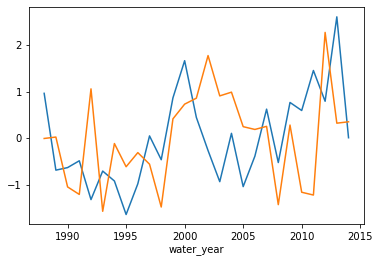

In [419]:
# This does not work very well...
sublimation_cires_totals = winter_cires_df.groupby(winter_cires_df.water_year).sum()['sbsno']
normalize_data(sublimation_ncep_totals.loc[1988:2014]).plot()
normalize_data(sublimation_taylor_totals.loc[1988:2014]).plot()

This does not seem to compare well...

### Grab NARR data and try looking at the same thing? Not working right now, not really interested in this though, can use this if needed https://github.com/xarray-contrib/xoak